In [28]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.spatial import distance
from scipy.stats.mstats import gmean
from sklearn.linear_model import LinearRegression
%matplotlib inline
from itertools import combinations
from itertools import chain
import sys
import os
import copy
sns.set_style('white')
sns.set_style('ticks')
sns.set_color_codes()

fgm_simulation_path = '/Users/grantkinsler/Documents/Stanford/Research/StarryNight/Git/starry-night/Simulations/FGM_simulation_callable.py'
sys.path.append(os.path.dirname(os.path.expanduser(fgm_simulation_path)))
from FGM_simulation_callable import simulation, nball_pull, gaussian_fitness

tools_path = '../code/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
np.random.seed(953527608) # for exact figure reproducibility use this seed
# np.random.seed(None)

In [4]:
fitness_data = p.read_csv('../data/DoubleBC_Merged_Fitness_Atish_Default_AllConditions.csv')

In [5]:
fitness_data.columns

Index(['13.1_error', '13.1_fitness', '13.2_error', '13.2_fitness',
       '13.3_error', '13.3_fitness', '18.1_error', '18.1_fitness',
       '18.2_error', '18.2_fitness',
       ...
       '1BB_0.2MNaCl_fitness', '1BB_0.2MNaCl_error', '1BB_0.2MKCl_fitness',
       '1BB_0.2MKCl_error', '1BB_0.5MKCl_fitness', '1BB_0.5MKCl_error',
       '1BB_0.5%Raf_fitness', '1BB_0.5%Raf_error', '1BB_1%Gly_fitness',
       '1BB_1%Gly_error'],
      dtype='object', length=111)

In [6]:
old_conditions = {
                  '3':['3.1','3.2','3.3'],
                  '6':['6.1','6.2','6.3'],
                  '13':['13.1','13.2','13.3'],
                  '18':['18.1','18.2','18.3'],
                  '20':['20.1','20.2','20.3'],
                  '21':['21.1','21.2','21.3'],
                  '23':['23.1','23.2','23.3']
                 }

bigbatch_conditions = {
                        '1BB_M3':['A','B','C','D'],
                        '1BB_Baffle':['E','F'],
                        '1BB_1.4%Gluc' :['G','H'],
                        '1BB_1.8%Gluc' :['I','J'],
                        '1BB_0.2MNaCl' :['K','L'],
                        '1BB_0.2MKCl' :['O'],
                        '1BB_0.5MKCl' :['P'],
#                         '1BB_8.5uMGdA' :['Q','R'],
#                         '1BB_17uMGdA' :['S','T'],
#                         '1BB_2ugFlu' :['U','V'],
#                         '1BB_0.5ugFlu' :['W','X'],
                        '1BB_0.2MNaCl' :['Y','Z'],
                        '1BB_0.5%Raf' :['AA','BB'],
                        '1BB_1%Gly' :['CC','DD'],
#                         '1BB_1%EtOH' :['EE','FF'],
#                         '1BB_SucRaf' :['GG'],
                      }


# m3_conditions = {**old_conditions,}
conditions = {**old_conditions, **bigbatch_conditions}
all_conditions = conditions.keys()
all_reps = [rep for reps in conditions.values() for rep in reps]

m3_conditions = list(old_conditions.keys()) + ['1BB_M3']
m3_reps = [rep for condition in m3_conditions for rep in conditions[condition]]


In [7]:
this_data = fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
this_data = this_data.dropna()

this_data = this_data.sort_values('barcode')

n_folds = 5
n_mutants_final = len(this_data.index) - len(this_data.index)%n_folds

drop_indices = np.random.choice(this_data.index, len(this_data.index)-n_mutants_final, replace=False)

this_data = this_data.drop(drop_indices)

# fitness = this_data[[col+'_fitness' for col in all_conditions]].values
# error = this_data[[col+'_error' for col in all_conditions]].values

fitness = this_data[[col+'_fitness' for col in all_reps]].values
error = this_data[[col+'_error' for col in all_reps]].values
# 
n_mutants = fitness.shape[0]
n_conditions = fitness.shape[1]

In [114]:
drop_indices

array([167])

In [115]:
print(n_mutants,n_conditions)

145 39


In [8]:
fitness_cols = np.asarray([col for col in all_reps])

m3_rep_indices = np.where(np.isin(fitness_cols,m3_reps))[0]
other_rep_indices = np.where(~np.isin(fitness_cols,m3_reps))[0]

2
2
2
2
2
2
2
2
2
2


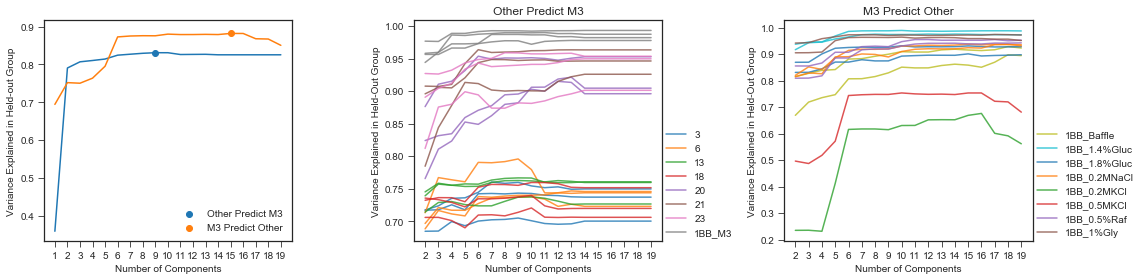

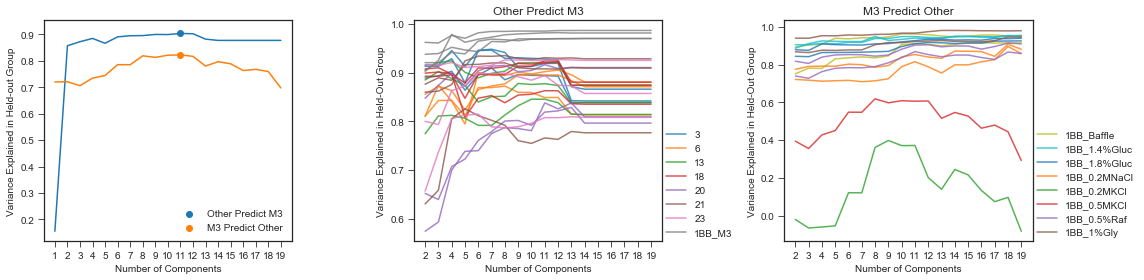

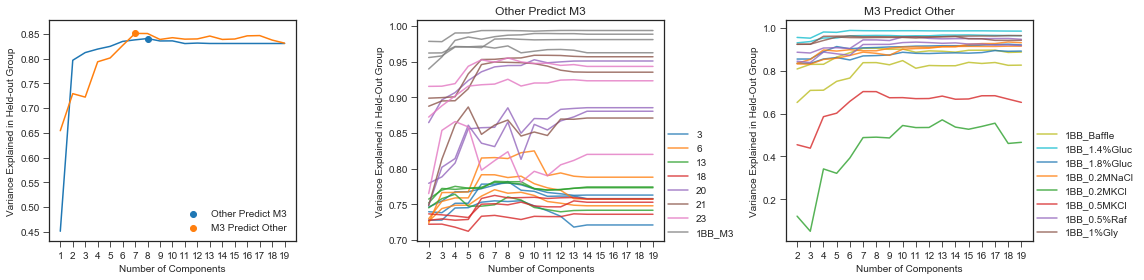

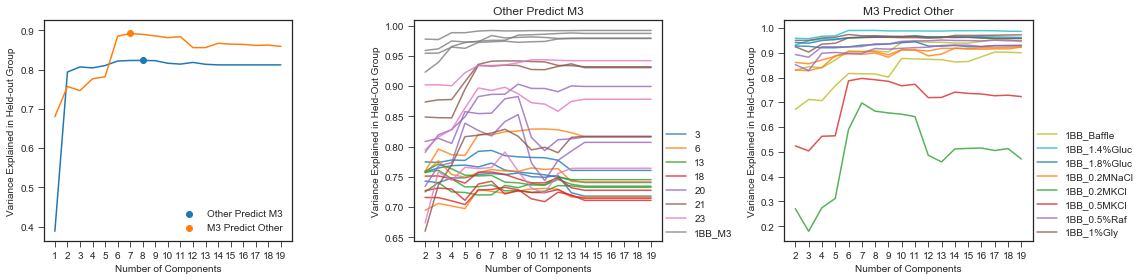

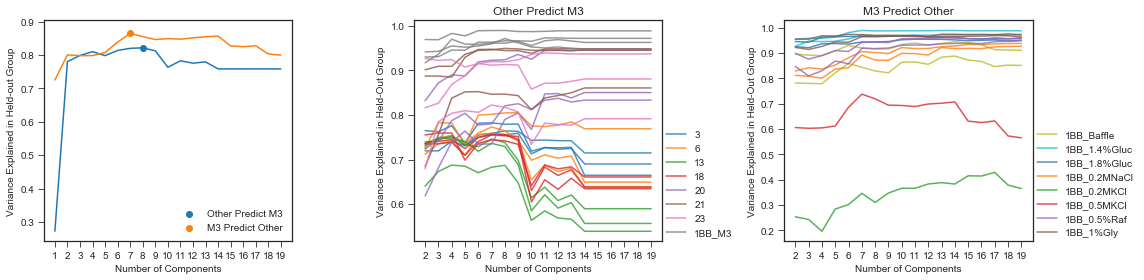

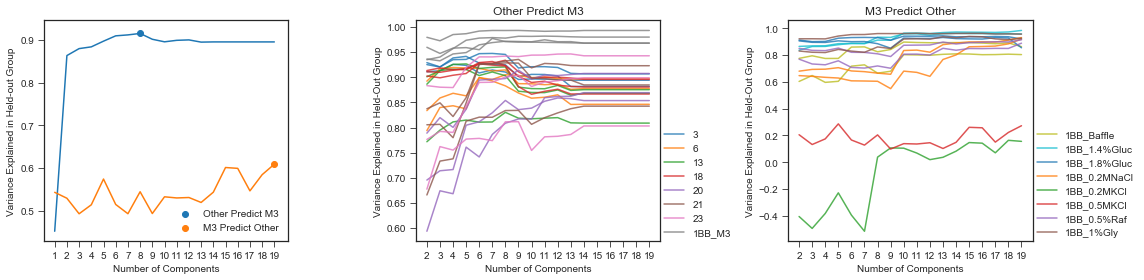

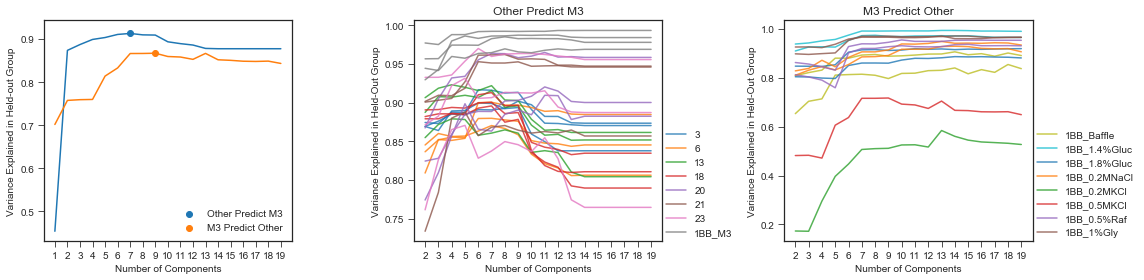

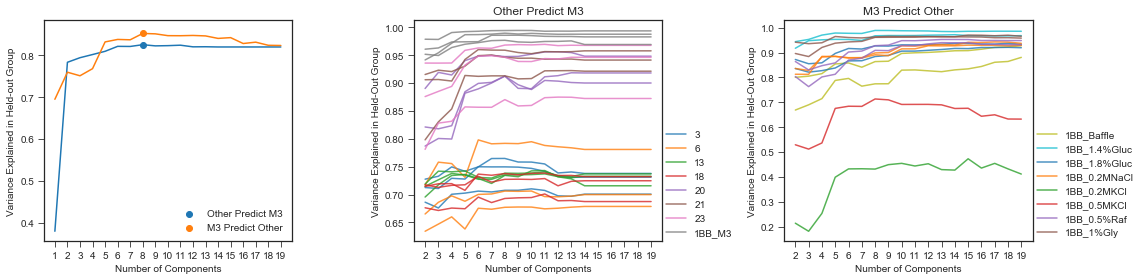

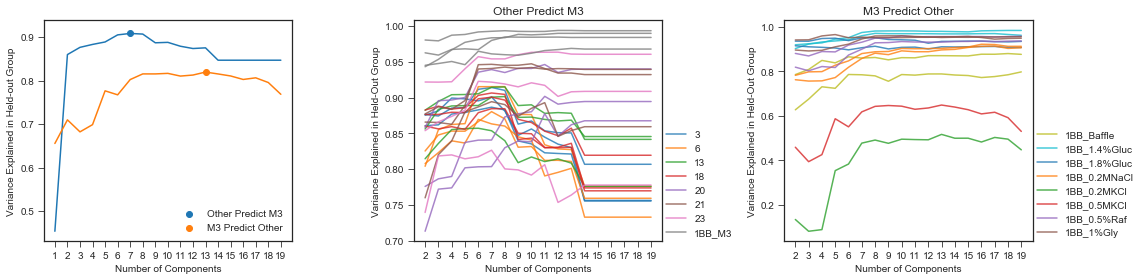

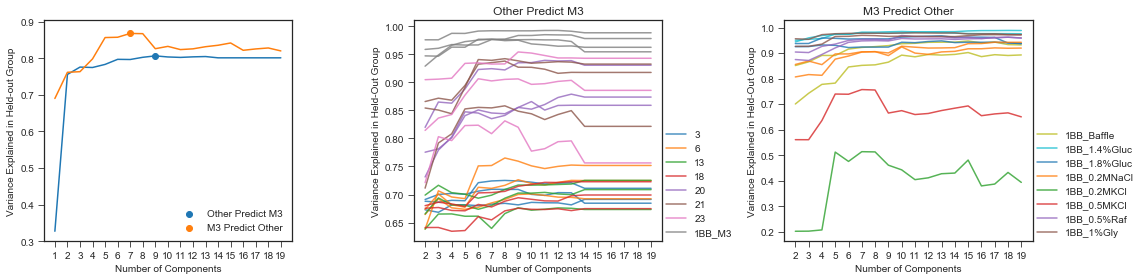

In [96]:
for t in range(10):
    condition_folds = [m3_rep_indices,other_rep_indices]
    fold_names = ['Other Predict M3','M3 Predict Other']
    n_folds = 2 
    mutant_permutation = np.random.permutation(n_mutants)
    mutant_folds = [sorted(mutant_permutation[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]

    ax = plt.figure(figsize=(16,4))
    folds = [(mutant_folds[i],condition_folds[i]) for i in range(2)]
    print(len(folds))
    
    all_fold, by_fold, by_condition = tools.SVD_predictions(fitness,folds,fitness.shape[0],fitness.shape[1],2)
    
    plt.subplot(1,3,1)
    max_rank = len(by_fold[0])
    for fold in range(n_folds):
        this_fold = by_fold[fold]
        plt.plot(this_fold )
        plt.scatter(range(0,max_rank)[np.where(this_fold ==np.max(this_fold))[0][0]],np.max(this_fold),
                    color=sns.color_palette()[fold],alpha=1.0,label=fold_names[fold])
    
    plt.xticks(np.arange(0,max_rank,1),np.arange(1,max_rank+1,1))
    plt.legend()
    plt.xlabel('Number of Components')
    plt.ylabel('Variance Explained in Held-out Group')
    
    start = 1
    for fold in range(n_folds):
        plt.subplot(1,3,fold+2)
        this_fold = by_condition[fold]
        
        this_fold = np.asarray(this_fold).swapaxes(0,1)
        max_rank = len(by_fold[0])
        already_plotted = []
        for k in range(this_fold.shape[0]):
            condition_name = [name for name, reps in conditions.items() for rep in reps if rep == fitness_cols[condition_folds[fold]][k]][0]
            index = np.where(np.asarray(list(conditions.keys()))==condition_name)[0][0]
            
            index =  index % len(condition_colors)
            if condition_name not in already_plotted:
                plt.plot(this_fold[k][start:],label=condition_name,color=condition_colors[index],alpha=0.8)
                already_plotted.append(condition_name)
            else:
                plt.plot(this_fold[k][start:],color=condition_colors[index],alpha=0.8)
        
        plt.xticks(np.arange(0,max_rank-start,1),np.arange(start+1,max_rank+1,1))
        plt.legend(loc=(1.0,0.0))
        plt.xlabel('Number of Components')
        plt.ylabel('Variance Explained in Held-Out Group')
        plt.title(fold_names[fold])
    plt.tight_layout()
    plt.savefig(f'supplemental_figures/prediction_m3_trial{t}.pdf',bbox_inches='tight')
#     tools.svd_cross_validation_figure(ax,fitness,error,folds,0)

In [67]:




for t in range(10):
    condition_folds = [m3_rep_indices,other_rep_indices]
    fold_names = ['Other Predict M3','M3 Predict Other']
    n_folds = 2 
    mutant_permutation = np.random.permutation(n_mutants)
    mutant_folds = [sorted(mutant_permutation[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]

    ax = plt.figure(figsize=(16,4))
    folds = [(mutant_folds[i],condition_folds[i]) for i in range(2)]
    print(len(folds))
    
    all_fold, by_fold, by_condition = tools.SVD_predictions(fitness,folds,fitness.shape[0],fitness.shape[1],2)
    
    plt.subplot(1,3,1)
    max_rank = len(by_fold[0])
    for fold in range(n_folds):
        this_fold = by_fold[fold]
        plt.plot(this_fold )
        plt.scatter(range(0,max_rank)[np.where(this_fold ==np.max(this_fold))[0][0]],np.max(this_fold),
                    color=sns.color_palette()[fold],alpha=1.0,label=fold_names[fold])
    
    plt.xticks(np.arange(0,max_rank,1),np.arange(1,max_rank+1,1))
    plt.legend()
    plt.xlabel('Number of Components')
    plt.ylabel('Variance Explained in Held-out Group')
    
    start = 1
    for fold in range(n_folds):
        plt.subplot(1,3,fold+2)
        this_fold = by_condition[fold]
        
        this_fold = np.asarray(this_fold).swapaxes(0,1)
        max_rank = len(by_fold[0])
        already_plotted = []
        for k in range(this_fold.shape[0]):
            condition_name = [name for name, reps in conditions.items() for rep in reps if rep == fitness_cols[condition_folds[fold]][k]][0]
            index = np.where(np.asarray(list(conditions.keys()))==condition_name)[0][0]
            
            index =  index % len(condition_colors)
            if condition_name not in already_plotted:
                plt.plot(this_fold[k][start:],label=condition_name,color=condition_colors[index],alpha=0.8)
                already_plotted.append(condition_name)
            else:
                plt.plot(this_fold[k][start:],color=condition_colors[index],alpha=0.8)
        
        plt.xticks(np.arange(0,max_rank-start,1),np.arange(start+1,max_rank+1,1))
        plt.legend(loc=(1.0,0.0))
        plt.xlabel('Number of Components')
        plt.ylabel('Variance Explained in Held-Out Group')
        plt.title(fold_names[fold])
    plt.tight_layout()
    plt.savefig(f'supplemental_figures/prediction_m3_trial{t}.pdf',bbox_inches='tight')
#     tools.svd_cross_validation_figure(ax,fitness,error,folds,0)

(14, 19)

In [88]:
old_c = m3_rep_indices
old_m = range(n_mutants)
new_c = other_rep_indices 
this_data = fitness

m3_fitness = this_data[np.repeat(old_m,len(old_c)),np.tile(old_c,len(old_m))].reshape(len(old_m),len(old_c))
other_fitness = this_data[np.repeat(old_m,len(new_c)),np.tile(new_c,len(old_m))].reshape(len(old_m),len(new_c))
# SVD on m3 data with all mutants
U, s2, V2 = np.linalg.svd(m3_fitness)

m3_condition_weights = np.dot(np.diag(s2),V2)



reg = LinearRegression(fit_intercept=False).fit(U[:,:s2.shape[0]],other_fitness)

other_condition_weights = reg.coef_.swapaxes(0,1)




/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


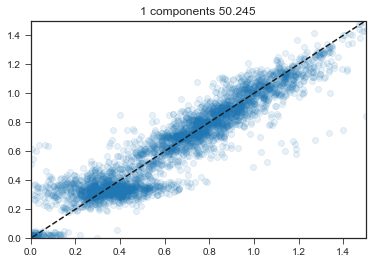

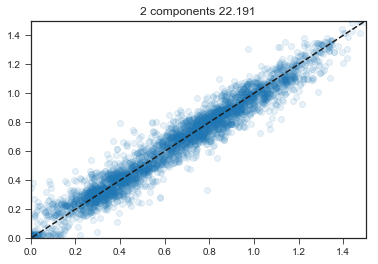

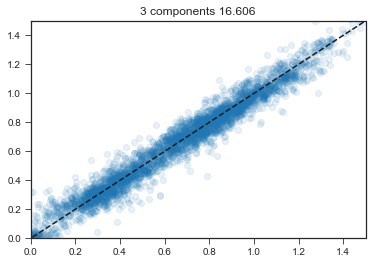

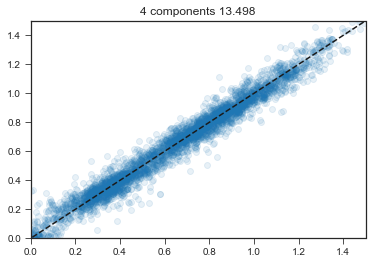

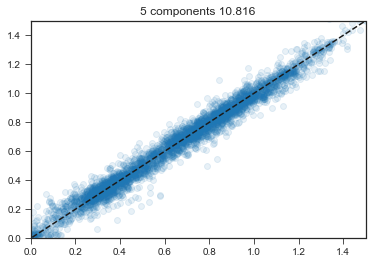

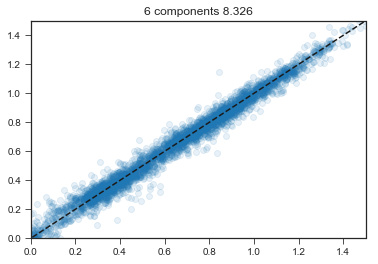

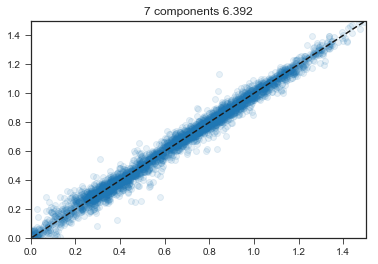

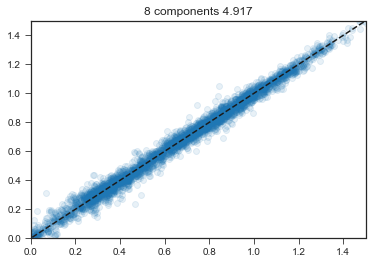

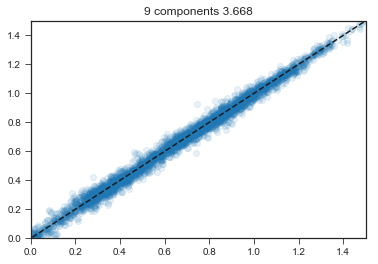

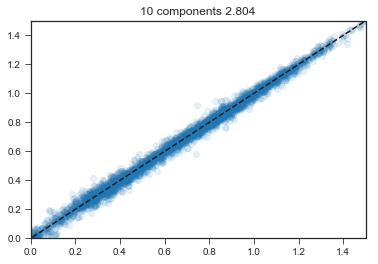

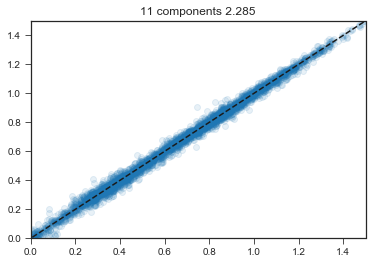

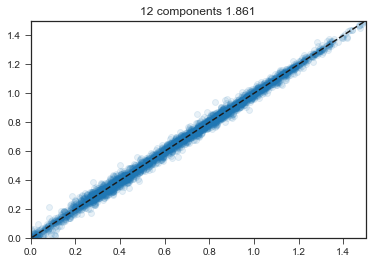

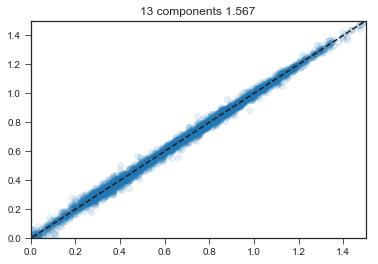

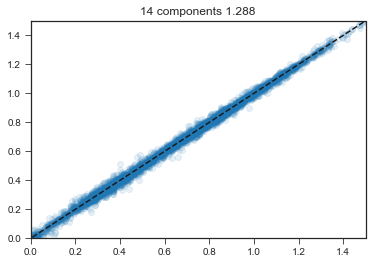

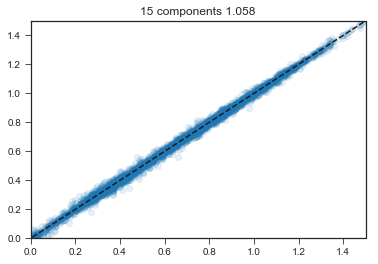

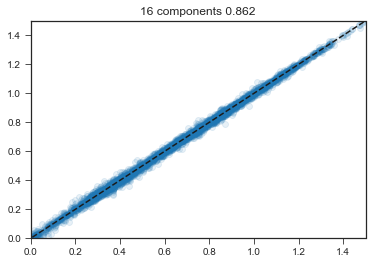

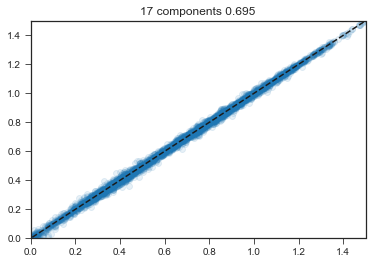

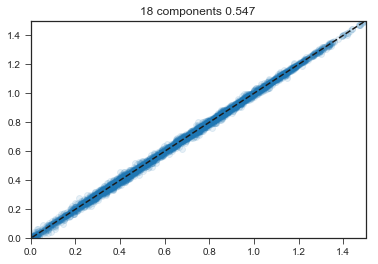

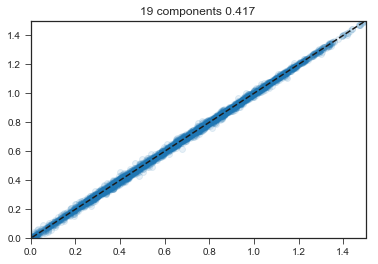

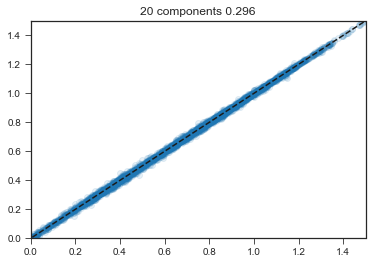

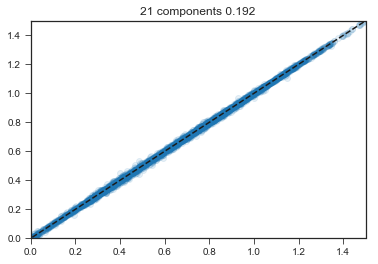

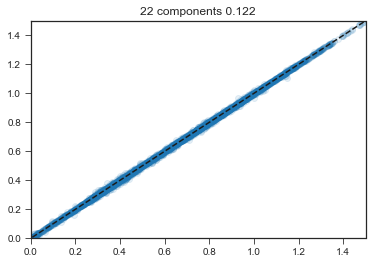

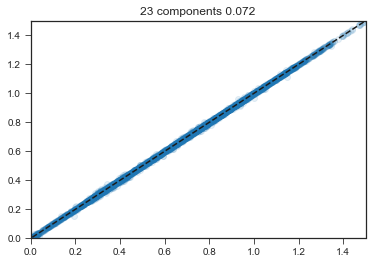

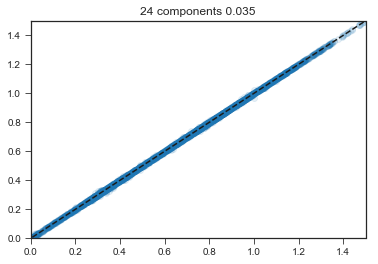

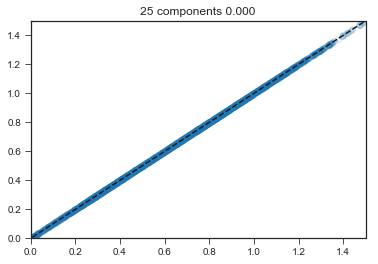

In [109]:
fit_mse = []

for k in range(1,s2.shape[0]+1):

    svd_fitness = np.dot(U[:,:k],m3_condition_weights[:k,:])
    this_mse = np.sum(np.square(m3_fitness.flatten()-svd_fitness.flatten()))
    fit_mse.append(this_mse)
    plt.figure()
    plt.title(f'{k} components {this_mse:.3f}')
    plt.scatter(m3_fitness.flatten(),svd_fitness.flatten(),alpha=0.1)
    plt.plot([-4,2],[-4,2],'k--')
    plt.xlim(0,1.5)
    plt.ylim(0,1.5)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


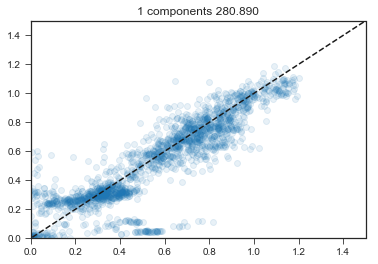

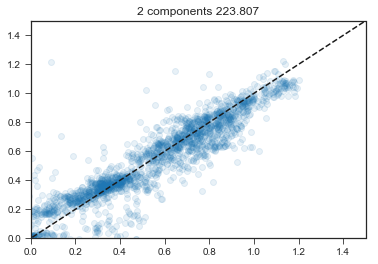

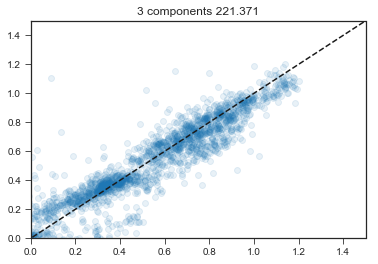

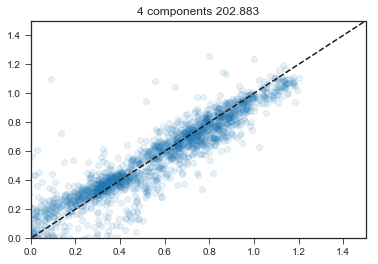

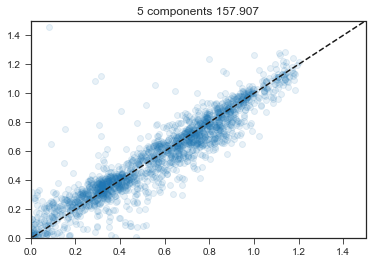

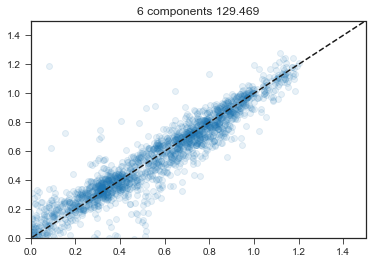

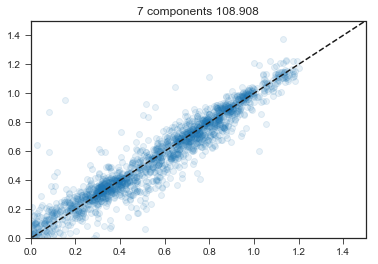

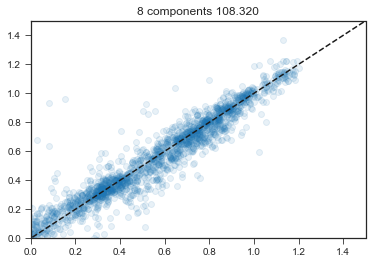

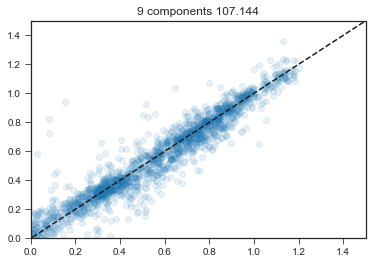

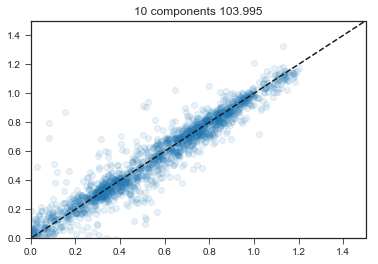

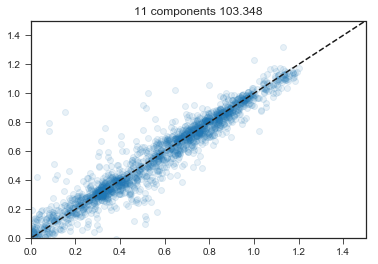

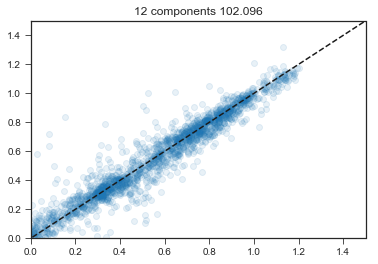

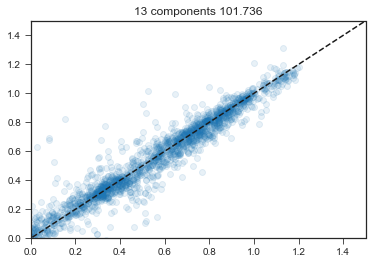

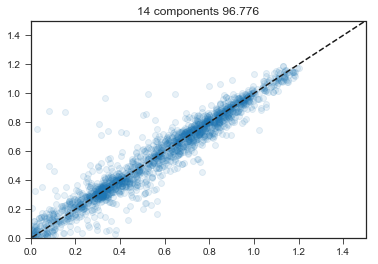

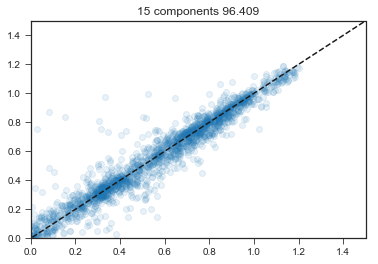

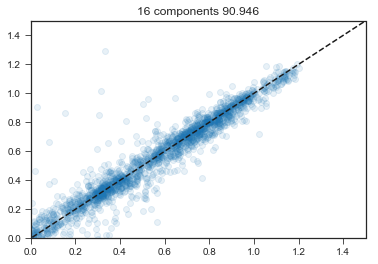

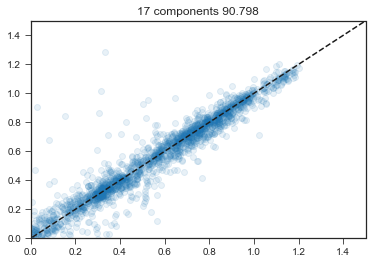

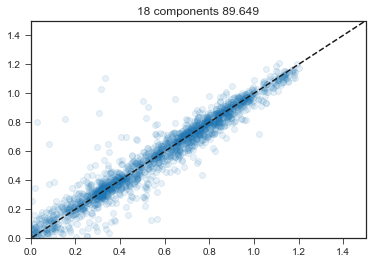

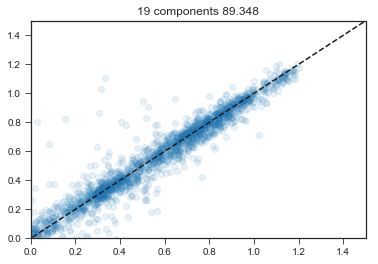

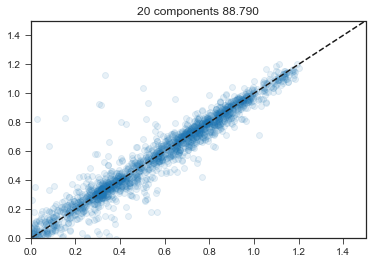

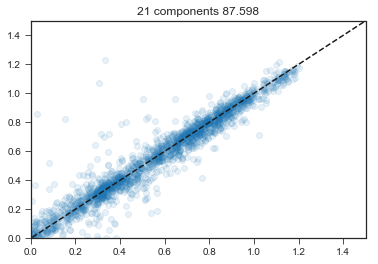

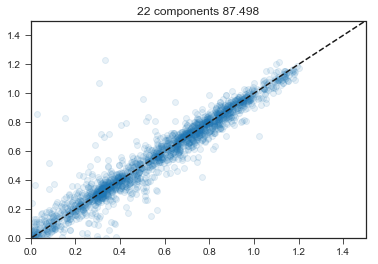

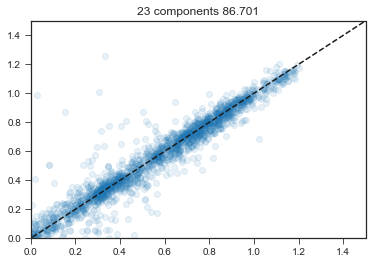

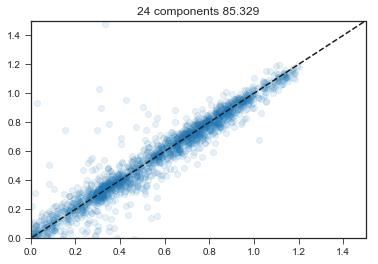

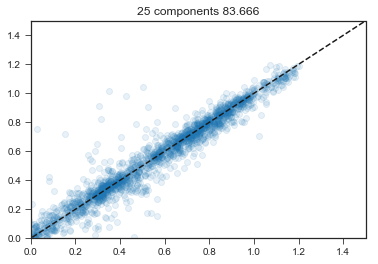

In [110]:
predict_mse = []

for d in range(1,s2.shape[0]+1):

    predicted_fitness = np.dot(U[:,:d],other_condition_weights[:d,:])
    
    this_mse = np.sum(np.square(other_fitness.flatten()-predicted_fitness.flatten()))
    predict_mse.append(this_mse)
    plt.figure()
    plt.title(f'{d} components {this_mse:.3f}')
    plt.scatter(other_fitness.flatten(),predicted_fitness.flatten(),alpha=0.1)
    plt.plot([-4,2],[-4,2],'k--')
    plt.xlim(0,1.5)
    plt.ylim(0,1.5)

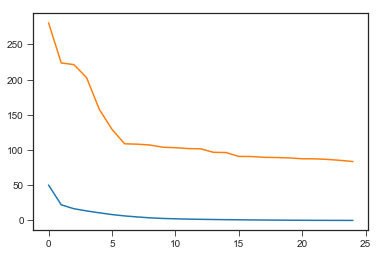

In [111]:
plt.plot(fit_mse)
plt.plot(predict_mse)

In [69]:
reg = LinearRegression(fit_intercept=False).fit(U[:,:s2.shape[0]],m3_fitness)

In [108]:
U[:,:1]

array([[-0.04406576],
       [-0.13804843],
       [-0.10624164],
       [-0.10108575],
       [-0.12940898],
       [-0.12862571],
       [-0.03867174],
       [-0.13372619],
       [-0.12830989],
       [-0.09141758],
       [-0.08696874],
       [-0.07476816],
       [-0.09560612],
       [-0.09352957],
       [-0.06265431],
       [-0.0991295 ],
       [-0.04026535],
       [-0.02858561],
       [-0.10335268],
       [-0.13683148],
       [-0.03912104],
       [-0.06809763],
       [-0.10970742],
       [-0.09996001],
       [-0.08372738],
       [-0.08615105],
       [-0.08021332],
       [-0.07955005],
       [-0.04208377],
       [-0.09685596],
       [-0.09605316],
       [-0.12680487],
       [-0.09767383],
       [-0.12080033],
       [-0.08111262],
       [-0.08496567],
       [-0.00044986],
       [-0.1270467 ],
       [-0.09627287],
       [-0.09707233],
       [-0.09575789],
       [-0.114736  ],
       [-0.12416293],
       [-0.09765033],
       [-0.12378479],
       [-0

In [83]:
reg.coef_.swapaxes(0,1)

array([[-8.08339132e+00, -8.50161090e+00, -8.34376711e+00,
        -9.36623777e+00, -8.95193662e+00, -1.16149040e+01,
        -1.03323014e+01, -1.00117308e+01, -7.26466878e+00,
        -8.21143204e+00, -9.08948246e+00, -9.25197277e+00,
        -8.92051205e+00, -8.93370669e+00, -7.23018792e+00,
        -8.12325000e+00, -8.26771940e+00, -7.32468795e+00,
        -8.80465012e+00, -8.43996058e+00, -8.55041734e+00,
        -7.09205092e+00, -7.60229399e+00, -7.42490211e+00,
        -8.29667666e+00],
       [-1.18343589e+00, -6.99684195e-01, -8.37251553e-01,
        -1.81000509e+00, -1.08639235e+00, -1.38252110e+00,
        -8.97721155e-01, -1.16402196e+00, -1.03928225e+00,
        -5.37779329e-01, -3.18467531e-01, -5.47361916e-01,
         1.38218450e+00,  1.58968760e+00,  1.08145969e+00,
         9.51233434e-01,  9.04671999e-01,  1.42986633e+00,
         7.46284672e-01,  1.22911513e+00,  1.60473107e+00,
         3.23869478e-01,  3.31839763e-01,  5.06500078e-01,
         8.21307424e-01],
    

In [81]:
np.allclose(m3_fitness,np.dot(U[:,:s2.shape[0]],np.dot(np.diag(s2),V2)))

True

In [45]:

for k in range(m3.shape[1]):
    reg = LinearRegression(fit_intercept=False).fit(U.T,m3_fitness[:,k])
    print(re)

In [68]:
reg = LinearRegression(fit_intercept=False).fit(U[:,:s2.shape[0]],m3_fitness[:,0])

reg.coef_

array([-8.08339132e+00, -1.18343589e+00, -2.59604166e-01,  7.79046558e-01,
        1.38172295e-01, -3.13017120e-02,  6.56373368e-02, -2.97512826e-01,
        6.25622149e-03, -3.13740881e-01,  3.05975392e-01, -1.29057803e-02,
        1.08815848e-01, -1.72691052e-01,  9.07387729e-02, -6.68753922e-02,
       -1.16449788e-02, -5.93223225e-03,  3.98786564e-02, -2.85406793e-02,
       -5.34253910e-02, -6.83528918e-02,  5.81810107e-03,  2.66039214e-02,
       -1.06059151e-02])

In [61]:
U.shape

(145, 145)

In [59]:
len(m3_fitness[0])

25

0.12076186404663289 0.007666215088295292 0.06348208640879324
0.9296921467046838


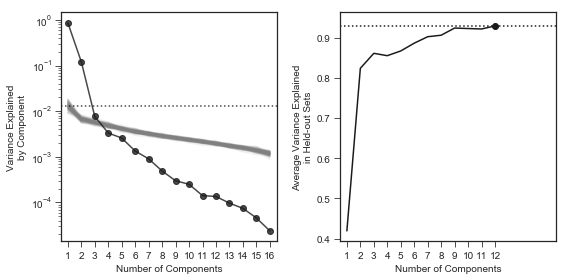

In [104]:
n_pulls = 100
# n_folds = 8

f = fitness

folds = tools.make_folds(f.shape[0],f.shape[1],n_folds)

plt.figure(figsize=(8,4))
    
ax = plt.subplot(1,2,1)

tools.svd_noise_comparison_figure(ax,fitness,error,n_pulls,yscale='log')
plt.yscale('log')
# plt.title(f'{err_names[e]} ({err:.1})')
plt.ylabel('Variance Explained\nby Component')
# ax.text(-0.1,1.1,chr(65+e),weight='bold', transform=ax.transAxes)
#     ax.set_aspect('equal')

ax = plt.subplot(1,2,2)

tools.svd_cross_validation_figure(ax,fitness,error,folds,0)

plt.ylabel('Average Variance Explained\nin Held-out Sets')
plt.xlabel('Number of Components')

plt.tight_layout()
# ax.text(-0.11,1.1,chr(65+4+e),weight='bold', transform=ax.transAxes)

# plt.savefig('figure5_replicates.pdf',bbox_inches='tight')

In [ ]:
prediction_folds = 





tools.SVD_predictions

In [ ]:
# SVD on the data
this_set = fitness
U, s, V = np.linalg.svd(fitness)
print(s)

n_pulls = 1000
noise_s_list = []
# SVD on just the noise
for i in range(n_pulls):
    this_set = np.asarray([np.random.normal(0,e) for e in error.flatten()]).reshape(n_mutants,n_conditions)
    U, noise_s, V = np.linalg.svd(this_set)
    noise_s_list.append(noise_s)

max_detectable = np.where(s < noise_s[0])[0][0]
print(max_detectable)
    
line, = plt.plot(np.arange(1,max_detectable+1),np.square(s[:max_detectable])/np.sum(np.square(s)),marker='.',alpha=0.8)
plt.plot(np.arange(max_detectable+1,len(s)+1),np.square(s[max_detectable:])/np.sum(np.square(s)),color = line.get_color(),alpha=0.8)
plt.plot(range(max_detectable+1,n_conditions+1),noise_s[:n_conditions-max_detectable]/np.sum(s),'--',color = line.get_color(),alpha=0.8)
    

    # expected theoretical max
#     sv = np.sqrt(2)*np.sqrt(err)*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
#     plt.axhline(sv/np.sum(s),linestyle=':',color = line.get_color(),alpha=0.8)
    
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels),loc=(1.0,0.0))
plt.xlabel('Number of Singular Values (dimensions)')
plt.ylabel('Contribution of Singular Value')
plt.xlim(0,n_conditions)
plt.xticks(np.arange(0,25,5),np.arange(0,25,5))
plt.gca().set_xticks(range(n_conditions),True)

plt.figure()

# plt.axvline(true_d+1,color='k',linestyle=':',alpha=0.8)
# plt.figure()
# for e in range(len(err_list[:end])):
#     err = err_list[e]
#     this_set = np.asarray([np.random.normal(f.flatten()[i],np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
#     U, s, V = np.linalg.svd(this_set)
# #     s = s/np.sum(s)
# # plt.legend()

#     this_set = np.asarray([np.random.normal(0,np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
#     U, noise_s, V = np.linalg.svd(this_set)
# #     noise_s = noise_s/np.sum(noise_s)
#     if err != 0:
#         max_detectable = np.where(s < noise_s[0])[0][0]
#     else:
#         max_detectable = true_d
#     if max_detectable > true_d:
#         max_detectable = true_d+1
    
#     line, = plt.plot(np.arange(2,max_detectable+1),np.square(s[1:max_detectable])/np.sum(np.square(s)),marker='.',alpha=0.8,label=r'$\sigma_m^2 ={}$'.format(err))
#     plt.plot(np.arange(max_detectable+1,len(s)+1),np.square(s[max_detectable:])/np.sum(np.square(s)),color = line.get_color(),alpha=0.8)
#     plt.plot(range(max_detectable+1,max_d+1),np.square(noise_s[:max_d-max_detectable])/np.sum(np.square(s)),'--',color = line.get_color(),alpha=0.8)
    
#     # empirical max
# #     plt.axhline(noise_s[0],linestyle=':',color = line.get_color(),alpha=0.8)
    
#     # expected theoretical max
#     sv = np.sqrt(2)*np.sqrt(err)*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
#     plt.axhline(np.square(sv)/np.sum(np.square(s)),linestyle=':',color = line.get_color(),alpha=0.8)
    
#     handles, labels = plt.gca().get_legend_handles_labels()
#     plt.legend(reversed(handles), reversed(labels),loc=(1.0,0.0))
#     plt.xlabel('Number of Singular Values (dimensions)')
#     plt.ylabel('Contribution of Singular Value')
#     plt.xlim(0,20)
#     plt.xticks(np.arange(0,25,5),np.arange(0,25,5))
#     plt.gca().set_xticks(range(20),True)
# #     plt.ylim(-0.1,2.4)
# #     plt.savefig('SVDAnalysis/buildup_d10_take3_{}.pdf'.format(e),bbox_inches='tight')



[25.37040336  3.11047947  1.81307224  1.01270222  0.85399755  0.75375094
  0.65203829  0.50493728  0.26796122]
9


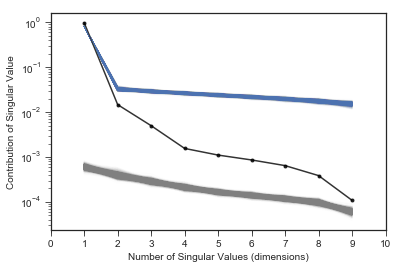

In [46]:
# SVD on the data
this_set = fitness
U, s, V = np.linalg.svd(fitness)
print(s)

n_pulls = 1000
noise_s_list = []
# SVD on just the noise
for i in range(n_pulls):
    this_set = np.asarray([np.random.normal(0,e) for e in error.flatten()]).reshape(n_mutants,n_conditions)
    U, noise_s, V = np.linalg.svd(this_set)
    noise_s_list.append(noise_s)
    
perm_s_list = []
# SVD on just the noise
for i in range(n_pulls):
    this_set = np.random.permutation(fitness.ravel()).reshape(n_mutants,n_conditions)
    U, perm_s, V = np.linalg.svd(this_set)
    perm_s_list.append(perm_s)

# max_detectable = np.where(s < noise_s[0])[0][0]
max_detectable = n_conditions
print(max_detectable)
    
line, = plt.plot(np.arange(1,max_detectable+1),np.square(s[:max_detectable])/np.sum(np.square(s)),marker='.',color='black',alpha=0.8)

for i in range(n_pulls):
#     plt.plot(np.arange(max_detectable+1,len(s)+1),np.square(s[max_detectable:])/np.sum(np.square(s)),color = line.get_color(),alpha=0.8)
    plt.plot(range(1,n_conditions+1),np.square(noise_s_list[i])/np.sum(np.square(s)),color = 'gray',alpha=0.01)
    plt.plot(range(1,n_conditions+1),np.square(perm_s_list[i])/np.sum(np.square(s)),color = 'b',alpha=0.01)
             
    

    # expected theoretical max
#     sv = np.sqrt(2)*np.sqrt(err)*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
#     plt.axhline(sv/np.sum(s),linestyle=':',color = line.get_color(),alpha=0.8)
    
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels),loc=(1.0,0.0))
plt.xlabel('Number of Singular Values (dimensions)')
plt.ylabel('Contribution of Singular Value')
plt.xlim(0,n_conditions)
plt.xticks(np.arange(0,11,1),np.arange(0,11,1))
plt.gca().set_xticks(range(n_conditions),True)

plt.yscale('log')


[24.56010107  2.99688431  1.02100044  0.94194335  0.76364204  0.712004
  0.5042247   0.29118461]
[9.79952285e-01 1.45909842e-02 1.69354403e-03 1.44143214e-03
 9.47380178e-04 8.23587021e-04 4.13040720e-04 1.37746788e-04]
8


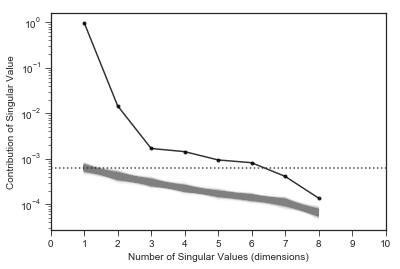

In [59]:
# SVD on the data
this_set = fitness
U, s, V = np.linalg.svd(fitness)
print(s)
print(np.square(s)/np.sum(np.square(s)))

n_pulls = 1000
noise_s_list = []
# SVD on just the noise
for i in range(n_pulls):
    this_set = np.asarray([np.random.normal(0,e) for e in error.flatten()]).reshape(n_mutants,n_conditions)
    U, noise_s, V = np.linalg.svd(this_set)
    noise_s_list.append(noise_s)
    
# perm_s_list = []
# # SVD on permutation
# for i in range(n_pulls):
#     this_set = np.random.permutation(fitness.ravel()).reshape(n_mutants,n_conditions)
#     U, perm_s, V = np.linalg.svd(this_set)
#     perm_s_list.append(perm_s)

# max_detectable = np.where(s < noise_s[0])[0][0]
max_detectable = n_conditions
print(max_detectable)
    
line, = plt.plot(np.arange(1,max_detectable+1),np.square(s[:max_detectable])/np.sum(np.square(s)),marker='.',color='black',alpha=0.8)

for i in range(n_pulls):
#     plt.plot(np.arange(max_detectable+1,len(s)+1),np.square(s[max_detectable:])/np.sum(np.square(s)),color = line.get_color(),alpha=0.8)
    plt.plot(range(1,n_conditions+1),np.square(noise_s_list[i])/np.sum(np.square(s)),color = 'gray',alpha=0.01)
#     plt.plot(range(1,n_conditions+1),perm_s_list[i],color = 'b',alpha=0.01)
mean_noise_max = np.mean(noise_s_list,axis=0)[0] 
plt.axhline(mean_noise_max**2/np.sum(np.square(s)),linestyle=':',color = 'k',alpha=0.8)


    
# handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels),loc=(1.0,0.0))
plt.xlabel('Number of Singular Values (dimensions)')
plt.ylabel('Contribution of Singular Value')
plt.xlim(0,n_conditions)
plt.xticks(np.arange(0,11,1),np.arange(0,11,1))
plt.gca().set_xticks(range(n_conditions),True)

plt.yscale('log')



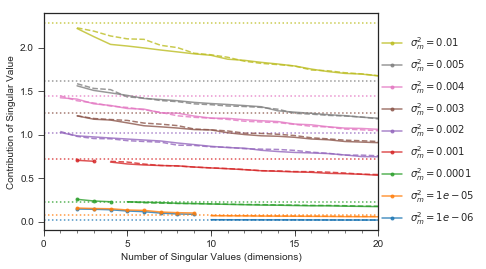

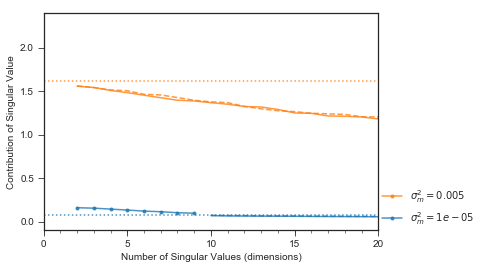

In [47]:
err_list = [1e-6,1e-5,1e-4,1e-3,2e-3,3e-3,4e-3,5e-3,1e-2]
end = len(err_list)
max_d = 50
true_d = 10-1
# plt.axvline(true_d+1,color='k',linestyle=':',alpha=0.8)
plt.figure()
for e in range(len(err_list[:end])):
    err = err_list[e]
    this_set = np.asarray([np.random.normal(f.flatten()[i],np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
    U, s, V = np.linalg.svd(this_set)
#     s = s/np.sum(s)
# plt.legend()

    this_set = np.asarray([np.random.normal(0,np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
    U, noise_s, V = np.linalg.svd(this_set)
#     noise_s = noise_s/np.sum(noise_s)
    if err != 0:
        max_detectable = np.where(s < noise_s[0])[0][0]
    else:
        max_detectable = true_d
    if max_detectable > true_d:
        max_detectable = true_d+1
    
    line, = plt.plot(np.arange(2,max_detectable+1),s[1:max_detectable],marker='.',alpha=0.8,label=r'$\sigma_m^2 ={}$'.format(err))
    plt.plot(np.arange(max_detectable+1,len(s)+1),s[max_detectable:],color = line.get_color(),alpha=0.8)
    plt.plot(range(max_detectable+1,max_d+1),noise_s[:max_d-max_detectable],'--',color = line.get_color(),alpha=0.8)
    
    # empirical max
#     plt.axhline(noise_s[0],linestyle=':',color = line.get_color(),alpha=0.8)
    
    # expected theoretical max
    sv = np.sqrt(2)*np.sqrt(err)*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
    plt.axhline(sv,linestyle=':',color = line.get_color(),alpha=0.8)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(reversed(handles), reversed(labels),loc=(1.0,0.0))
    plt.xlabel('Number of Singular Values (dimensions)')
    plt.ylabel('Contribution of Singular Value')
    plt.xlim(0,20)
    plt.xticks(np.arange(0,25,5),np.arange(0,25,5))
    plt.gca().set_xticks(range(20),True)
    plt.ylim(-0.1,2.4)
#     plt.savefig('SVDAnalysis/buildup_d10_take3_{}.pdf'.format(e),bbox_inches='tight')
plt.figure()

for e in [1,7]:
    err = err_list[e]
    this_set = np.asarray([np.random.normal(f.flatten()[i],np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
    U, s, V = np.linalg.svd(this_set)
#     s = s/np.sum(s)
# plt.legend()

    this_set = np.asarray([np.random.normal(0,np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
    U, noise_s, V = np.linalg.svd(this_set)
#     noise_s = noise_s/np.sum(noise_s)
    if err != 0:
        max_detectable = np.where(s < noise_s[0])[0][0]
    else:
        max_detectable = true_d
    if max_detectable > true_d:
        max_detectable = true_d+1
    
    line, = plt.plot(np.arange(2,max_detectable+1),s[1:max_detectable],marker='.',alpha=0.8,label=r'$\sigma_m^2 ={}$'.format(err))
    plt.plot(np.arange(max_detectable+1,len(s)+1),s[max_detectable:],color = line.get_color(),alpha=0.8)
    plt.plot(range(max_detectable+1,max_d+1),noise_s[:max_d-max_detectable],'--',color = line.get_color(),alpha=0.8)
    
    # empirical max
#     plt.axhline(noise_s[0],linestyle=':',color = line.get_color(),alpha=0.8)
    
    # expected theoretical max
    sv = np.sqrt(2)*np.sqrt(err)*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
    plt.axhline(sv,linestyle=':',color = line.get_color(),alpha=0.8)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(reversed(handles), reversed(labels),loc=(1.0,0.0))
    plt.xlabel('Number of Singular Values (dimensions)')
    plt.ylabel('Contribution of Singular Value')
    plt.xlim(0,20)
    plt.xticks(np.arange(0,25,5),np.arange(0,25,5))
    plt.gca().set_xticks(range(20),True)
    plt.ylim(-0.1,2.4)
#     plt.savefig('SVDAnalysis/buildup_d10_take3_iso_{}.pdf'.format(e),bbox_inches='tight')

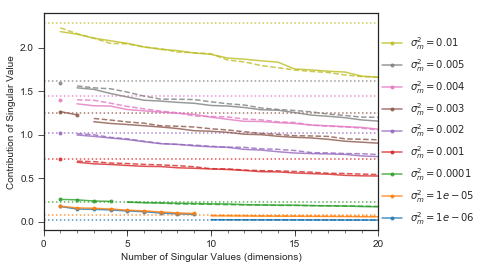

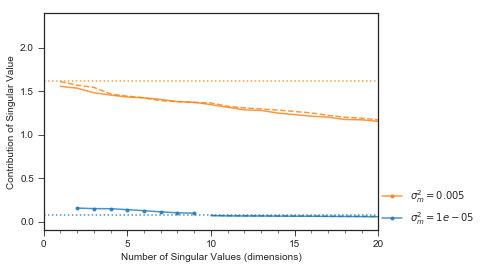

In [49]:
err_list = [1e-6,1e-5,1e-4,1e-3,2e-3,3e-3,4e-3,5e-3,1e-2]
end = len(err_list)
max_d = 50
true_d = 10-1
# plt.axvline(true_d+1,color='k',linestyle=':',alpha=0.8)
plt.figure()
for e in range(len(err_list[:end])):
    err = err_list[e]
    this_set = np.asarray([np.random.normal(f.flatten()[i],np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
    U, s, V = np.linalg.svd(this_set)
#     s = s/np.sum(s)
# plt.legend()

    this_set = np.asarray([np.random.normal(0,np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
    U, noise_s, V = np.linalg.svd(this_set)
#     noise_s = noise_s/np.sum(noise_s)
    if err != 0:
        max_detectable = np.where(s < noise_s[0])[0][0]
    else:
        max_detectable = true_d
    if max_detectable > true_d:
        max_detectable = true_d+1
    
    line, = plt.plot(np.arange(1,max_detectable+1),s[:max_detectable],marker='.',alpha=0.8,label=r'$\sigma_m^2 ={}$'.format(err))
    plt.plot(np.arange(max_detectable+1,len(s)+1),s[max_detectable:],color = line.get_color(),alpha=0.8)
    plt.plot(range(max_detectable+1,max_d+1),noise_s[:max_d-max_detectable],'--',color = line.get_color(),alpha=0.8)
    
    # empirical max
#     plt.axhline(noise_s[0],linestyle=':',color = line.get_color(),alpha=0.8)
    
    # expected theoretical max
    sv = np.sqrt(2)*np.sqrt(err)*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
    plt.axhline(sv,linestyle=':',color = line.get_color(),alpha=0.8)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(reversed(handles), reversed(labels),loc=(1.0,0.0))
    plt.xlabel('Number of Singular Values (dimensions)')
    plt.ylabel('Contribution of Singular Value')
    plt.xlim(0,20)
    plt.xticks(np.arange(0,25,5),np.arange(0,25,5))
    plt.gca().set_xticks(range(20),True)
    plt.ylim(-0.1,2.4)
#     plt.savefig('SVDAnalysis/buildup_d10_take3_{}.pdf'.format(e),bbox_inches='tight')
plt.figure()

for e in [1,7]:
    err = err_list[e]
    this_set = np.asarray([np.random.normal(f.flatten()[i],np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
    U, s, V = np.linalg.svd(this_set)
#     s = s/np.sum(s)
# plt.legend()

    this_set = np.asarray([np.random.normal(0,np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
    U, noise_s, V = np.linalg.svd(this_set)
#     noise_s = noise_s/np.sum(noise_s)
    if err != 0:
        max_detectable = np.where(s < noise_s[0])[0][0]
    else:
        max_detectable = true_d
    if max_detectable > true_d:
        max_detectable = true_d+1
    
    line, = plt.plot(np.arange(2,max_detectable+1),s[1:max_detectable],marker='.',alpha=0.8,label=r'$\sigma_m^2 ={}$'.format(err))
    plt.plot(np.arange(max_detectable+1,len(s)+1),s[max_detectable:],color = line.get_color(),alpha=0.8)
    plt.plot(range(max_detectable+1,max_d+1),noise_s[:max_d-max_detectable],'--',color = line.get_color(),alpha=0.8)
    
    # empirical max
#     plt.axhline(noise_s[0],linestyle=':',color = line.get_color(),alpha=0.8)
    
    # expected theoretical max
    sv = np.sqrt(2)*np.sqrt(err)*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
    plt.axhline(sv,linestyle=':',color = line.get_color(),alpha=0.8)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(reversed(handles), reversed(labels),loc=(1.0,0.0))
    plt.xlabel('Number of Singular Values (dimensions)')
    plt.ylabel('Contribution of Singular Value')
    plt.xlim(0,20)
    plt.xticks(np.arange(0,25,5),np.arange(0,25,5))
    plt.gca().set_xticks(range(20),True)
    plt.ylim(-0.1,2.4)
#     plt.savefig('SVDAnalysis/buildup_d10_take3_iso_{}.pdf'.format(e),bbox_inches='tight')

In [50]:
ACV = []
AMV = []
o_ds = [0.1,0.2,0.5]
m_ds = [0.1,0.2,0.5]
n_conditions = 50
n_mutants = 250
d_true = 10 
n_cvs = 1
n_folds = 5
mutant_center = np.asarray([0.0]+[0.0]*(d_true-1))

for o_dispersal in o_ds:
    for m_dispersal in m_ds:

        condition_points = []
        for c in range(n_conditions):
#             condition_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
            condition_points.append(list(nball_pull(d_true,o_dispersal,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
        mutant_points = []
        for m in range(n_mutants):
#             mutant_points.append(list(nball_pull(d_true,1.0,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
            mutant_points.append(list(nball_pull(d_true,m_dispersal,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
        Ancestor = np.asarray([0.0]+[0.0]*(d_true-1))
        Mutants = mutant_center + np.asarray(mutant_points)
#         print(Mutants)
        Conditions = np.asarray(condition_points)
        f = calculate_fitness_linear(Mutants,Conditions,Ancestor)
#         print(o_dispersal,m_dispersal)
        avg_mutant_var = (np.mean(np.nanvar(f,axis=0)))
        avg_condition_var = (np.mean(np.nanvar(f,axis=1)))
        condition_cv = (np.var(np.mean(f,axis=0))/np.mean(f))
        mutant_cv = (np.var(np.mean(f,axis=1))/np.mean(f))
#         real_fits,true_fits = SVD_predictions(f,f,folds,n_mutants,n_conditions,n_folds)
#         real_fits = real_fits/n_folds
        
#         non_mean_var_explain = (1-real_fits[0])/(d_true-1)
#         last_var_explain = (1-real_fits[d_true-1])


#         err_list = [0] + [i*avg_condition_var for i in [0.1,0.5,1.0,1.5,2.0,2.5,4.0,8.0,10]]
#         err_list = [0] + [i*non_mean_var_explain for i in [0.25,0.5,0.8,0.9,1.0,1.1,1.2,2.0,4.0]]
#         optimum_deviation = optimum_deviation_dict[sim_id]

        # d_true = 10
        # optimum_deviation = 1.0
        # fitness, sim_id, n_dim, n_mut, n_con = simulation(d_true,250,50,optimum_deviation=optimum_deviation,dry_run=False)
        # f = fitness

        d_est = []
        d_list = []
        for cv in range(n_cvs):
            fig = plt.figure(figsize=(10,5))
            plt.suptitle(r'd{0} {1} $CV_m=${2:.3g} $CV_c=${3:.3g} $AMV=${4:.3g} $ACV=${5:.3g}\n 2*ACV'.format(d_true,sim_id,mutant_cv,condition_cv,avg_mutant_var,avg_condition_var))
            counter = 1

            n_mutants = f.shape[0]
            n_conditions = f.shape[1]
            max_rank = int((n_folds-1)*n_conditions/n_folds)
            mutant_permutation = np.random.permutation(n_mutants)
            new_mutants = [sorted(mutant_permutation[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
            condition_permtutation = np.random.permutation(n_conditions)
            new_conditions = [sorted(condition_permtutation[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]


            folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]

            for err in err_list:
                ax = plt.subplot(2,5,counter)
                counter += 1
                plt.title(r'$err=${0:.3g}'.format(err))
                this_set = np.asarray([np.random.normal(f.flatten()[i],np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
                true_var_explained = var_explained(this_set,f)[0]

                real_fits,true_fits = SVD_predictions(this_set,f,folds,n_mutants,n_conditions,n_folds,mse=True)
                real_fits = real_fits/n_folds
        #         true_fits = true_fits/n_folds

                for perm in range(n_permutations):
                    permuted_mutants = copy.copy(this_set)

                    perm_fits, true_fits = SVD_predictions(permuted_mutants,f,folds,n_mutants,n_conditions,n_folds,permuted_mutants=True,mse=True)
                    perm_fits = perm_fits/n_folds


                    plt.plot(range(1,max_rank+1),perm_fits,color='gray',label=d_true,alpha=0.5,linestyle='--')
                    plt.scatter(range(1,max_rank+1)[np.where(perm_fits==np.min(perm_fits))[0][0]],np.min(perm_fits),color='gray',alpha=0.5,linestyle='--')

                plt.plot(range(1,max_rank+1),real_fits,color='k',label=d_true,alpha=1.0)
                plt.scatter(range(1,max_rank+1)[np.where(real_fits==np.min(real_fits))[0][0]],np.min(real_fits),color='k',alpha=1.0)

                plt.axvline(x=d_true,color='k',linestyle=':')

            fig.tight_layout()
            plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
#             plt.savefig('SVDAnalysis/simple_model_d{}_o{}_m{}_VE.pdf'.format(d_true,o_dispersal,m_dispersal),bbox_inches='tight')




NameError: name 'sim_id' is not defined

<Figure size 720x360 with 0 Axes>

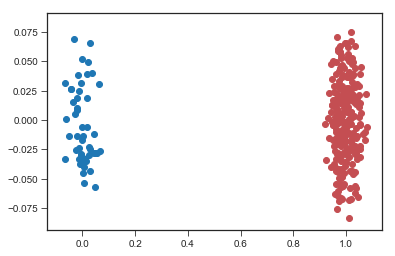

In [224]:
plt.scatter(np.asarray(condition_points).swapaxes(0,1)[0],np.asarray(condition_points).swapaxes(0,1)[1])
plt.scatter((mutant_center+np.asarray(mutant_points)).swapaxes(0,1)[0],(mutant_center+np.asarray(mutant_points)).swapaxes(0,1)[1],color='r')

In [82]:
print(np.var([1,2,3]*1),np.var([1,2,3]*2),np.var([1,2,3]*10))

0.6666666666666666 0.6666666666666666 0.6666666666666666


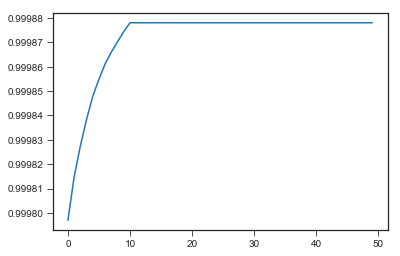

In [210]:
# SVD_predictions(f,f,folds,n_mutants,n_conditions,n_folds)
plt.plot(SVD_fits(f)[0])

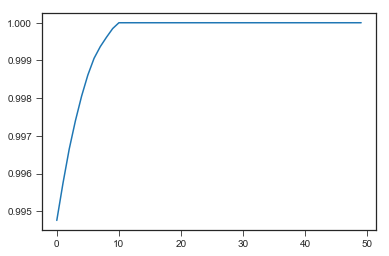

In [10]:
n_conditions = 50
n_mutants = 250
d_true = 10
mutant_center = np.asarray([1.0]+[0.0]*(d_true-1))
condition_points = []
for c in range(n_conditions):
#             condition_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
    condition_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
mutant_points = []
for m in range(n_mutants):
#             mutant_points.append(list(nball_pull(d_true,1.0,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
    mutant_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
Ancestor = np.asarray([2.0]+[0.0]*(d_true-1))
Mutants = mutant_center + np.asarray(mutant_points)
Conditions = np.asarray(condition_points)
f = calculate_fitness(Mutants,Conditions,Ancestor)
plt.plot(SVD_fits(f)[0])

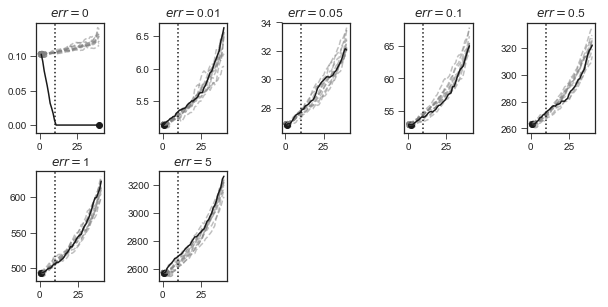

In [11]:
n_mutants = f.shape[0]
n_conditions = f.shape[1]
n_folds = 5
max_rank = int((n_folds-1)*n_conditions/n_folds)
n_permutations = 10
mutant_permutation = np.random.permutation(n_mutants)
new_mutants = [sorted(mutant_permutation[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
condition_permtutation = np.random.permutation(n_conditions)
new_conditions = [sorted(condition_permtutation[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]

n_trials = 1

folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]
counter = 1
fig = plt.figure(figsize=(10,5))
err_list = [0,0.01,0.05,0.1,0.5,1.0,5.0]
for err in err_list:
    for trial in range(n_trials):
        ax = plt.subplot(2,5,counter)

        plt.title(r'$err=${0:.3g}'.format(err))
        this_set = np.asarray([np.random.normal(f.flatten()[i],np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
        true_var_explained = var_explained(this_set,f)[0]

        real_fits,true_fits = SVD_predictions(this_set,f,folds,n_mutants,n_conditions,n_folds,mse=True)
        real_fits = real_fits/n_folds
    #         true_fits = true_fits/n_folds

        for perm in range(n_permutations):
            permuted_mutants = copy.copy(this_set)

            perm_fits, true_fits = SVD_predictions(permuted_mutants,f,folds,n_mutants,n_conditions,n_folds,permuted_mutants=True,mse=True)
            perm_fits = perm_fits/n_folds


            plt.plot(range(1,max_rank+1),perm_fits,color='gray',label=d_true,alpha=0.5,linestyle='--')
            plt.scatter(range(1,max_rank+1)[np.where(perm_fits==np.min(perm_fits))[0][0]],np.min(perm_fits),color='gray',alpha=0.5,linestyle='--')

        plt.plot(range(1,max_rank+1),real_fits,color='k',label=d_true,alpha=1.0)
        plt.scatter(range(1,max_rank+1)[np.where(real_fits==np.min(real_fits))[0][0]],np.min(real_fits),color='k',alpha=1.0)

        plt.axvline(x=d_true,color='k',linestyle=':')
    counter += 1
fig.tight_layout()
plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)

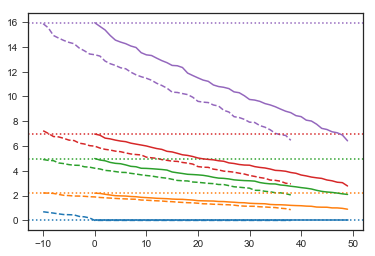

In [19]:
###### plt.plot(SVD_fits(f)[0],label=0)
end = 5
max_d = 10
for err in err_list[:end]:
    this_set = np.asarray([np.random.normal(f.flatten()[i],np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
    U, s, V = np.linalg.svd(this_set)
# plt.legend()
    plt.plot(np.arange(-10,len(s)-1-10),s[1:],'--')
#     plt.plot(np.arange(-10,len(s)-1-10),s[1:],'--')
plt.gca().set_prop_cycle(None)
# plt.figure()
for err in err_list[:end]:
    this_set = np.asarray([np.random.normal(0,np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
    U, s, V = np.linalg.svd(this_set)
# plt.legend()
    line, = plt.plot(s[:])
#     plt.gca()._get_lines.prop_cycler.prev()
    plt.axhline(s[0],linestyle=':',color = line.get_color())
# sv_random_matrix_theory = np.sqrt(2)*np.sqrt(np.asarray(err_list))*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
# for sv in sv_random_matrix_theory[:end]:
#     plt.axhline(sv,linestyle=":",color='k')

# plt.xlim(-11,1)

In [399]:
np.sqrt(2)*np.asarray(err_list)*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))

[0, 0.01, 0.05, 0.1, 0.5, 1.0]

In [409]:
np.sqrt(2)*np.sqrt(np.asarray(err_list))*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))

array([ 0.        ,  2.28824561,  5.11667274,  7.23606798, 16.18033989,
       22.88245611])

In [51]:
err_list = [0,0.0001,0.001,0.0025,0.005,0.0075,0.01]

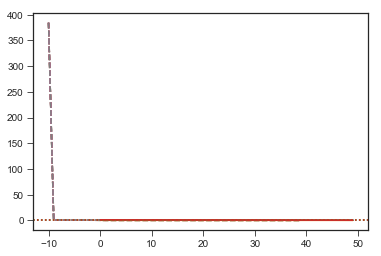

In [52]:
###### plt.plot(SVD_fits(f)[0],label=0)
end = 4
max_d = 10
for err in err_list[:end]:
    this_set = np.asarray([np.random.normal(f.flatten()[i],np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
    U, s, V = np.linalg.svd(this_set)
# plt.legend()
    plt.plot(np.arange(-10,len(s)-10),s[:],'--')
    plt.plot(np.arange(-10,len(s)-10),s[:],'--')
plt.gca().set_prop_cycle(None)
# plt.figure()
for err in err_list[:end]:
    this_set = np.asarray([np.random.normal(0,np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
    U, s, V = np.linalg.svd(this_set)
# plt.legend()
    line, = plt.plot(s[:])
#     plt.gca()._get_lines.prop_cycler.prev()
    plt.axhline(s[0],linestyle=':',color = line.get_color())
# sv_random_matrix_theory = np.sqrt(2)*np.sqrt(np.asarray(err_list))*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
# for sv in sv_random_matrix_theory[:end]:
#     plt.axhline(sv,linestyle=":",color='k')

# plt.xlim(-11,1)

(0, 20)

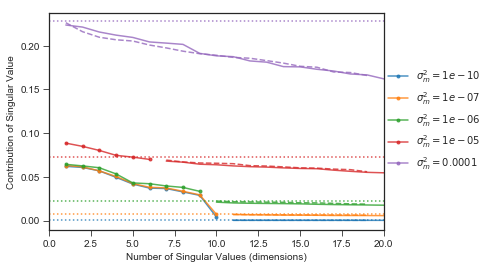

In [16]:
###### plt.plot(SVD_fits(f)[0],label=0)
d_true = 10
mutant_center = np.asarray([1.0]+[0.0]*(d_true-1))
condition_points = []
for c in range(n_conditions):
#             condition_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
    condition_points.append(list(nball_pull(d_true,0.05,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
mutant_points = []
for m in range(n_mutants):
#             mutant_points.append(list(nball_pull(d_true,1.0,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
    mutant_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
Ancestor = np.asarray([2.0]+[0.0]*(d_true-1))
Mutants = Ancestor + np.asarray(mutant_points)
Conditions = np.asarray(condition_points)
f = calculate_fitness(Mutants,Conditions,Ancestor)
# plt.plot(SVD_fits(f)[0])


end = 6
max_d = 20
true_d = 10-1
for err in err_list[:end]:
    this_set = np.asarray([np.random.normal(f.flatten()[i],np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
    U, s, V = np.linalg.svd(this_set)
#     s = s/np.sum(s)
# plt.legend()

    this_set = np.asarray([np.random.normal(0,np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
    U, noise_s, V = np.linalg.svd(this_set)
#     noise_s = noise_s/np.sum(noise_s)
    if err != 0:
        max_detectable = np.where(s < noise_s[0])[0][0]
    else:
        max_detectable = true_d
    
    line, = plt.plot(np.arange(1,max_detectable),s[1:max_detectable],marker='.',alpha=0.8,label=r'$\sigma_m^2 ={}$'.format(err))
    plt.plot(np.arange(max_detectable,len(s)),s[max_detectable:],color = line.get_color(),alpha=0.8)
    plt.plot(range(max_detectable,max_d),noise_s[:max_d-max_detectable],'--',color = line.get_color(),alpha=0.8)
    
    # empirical max
#     plt.axhline(noise_s[0],linestyle=':',color = line.get_color(),alpha=0.8)
    
    # expected theoretical max
    sv = np.sqrt(2)*np.sqrt(err)*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
    plt.axhline(sv,linestyle=':',color = line.get_color(),alpha=0.8)
    
plt.legend(loc=(1.0,0.25))
plt.xlabel('Number of Singular Values (dimensions)')
plt.ylabel('Contribution of Singular Value')
plt.xlim(0,20)

# sv_random_matrix_theory = np.sqrt(2)*np.sqrt(np.asarray(err_list))*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
# for sv in sv_random_matrix_theory[:end]:
#     
# plt.savefig('SVDAnalysis/sv_contribution_d10.pdf',bbox_inches='tight')
# plt.xlim(-11,1)

In [23]:
###### plt.plot(SVD_fits(f)[0],label=0)
end = 6
max_d = 50
true_d = 10-1
for err in err_list[:end]:
    this_set = np.asarray([np.random.normal(f.flatten()[i],np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
    U, s, V = np.linalg.svd(this_set)
#     s = s/np.sum(s)
# plt.legend()
    

    this_set = np.asarray([np.random.normal(0,np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
    U, noise_s, V = np.linalg.svd(this_set)
#     noise_s = noise_s/np.sum(noise_s)
    if err != 0:
        max_detectable = np.where(s < noise_s[0])[0][0]
    else:
        max_detectable = true_d
    
    line, = plt.plot(np.arange(1,max_detectable),s[1:max_detectable],marker='.',alpha=0.8,label=r'$\sigma_m^2 ={}$'.format(err))
    plt.plot(np.arange(max_detectable,len(s)),s[max_detectable:],color = line.get_color(),alpha=0.8)
    plt.plot(range(max_detectable,max_d),noise_s[:max_d-max_detectable],'--',color = line.get_color(),alpha=0.8)
    
    # empirical max
#     plt.axhline(noise_s[0],linestyle=':',color = line.get_color(),alpha=0.8)
    
    # expected theoretical max
    sv = np.sqrt(2)*np.sqrt(err)*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
    plt.axhline(sv,linestyle=':',color = line.get_color(),alpha=0.8)
    
plt.legend(loc=(1.0,0.25))
plt.xlabel('Number of Singular Values (dimensions)')
plt.ylabel('Contribution of Singular Value')

# sv_random_matrix_theory = np.sqrt(2)*np.sqrt(np.asarray(err_list))*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
# for sv in sv_random_matrix_theory[:end]:
#     
# plt.savefig('SVDAnalysis/sv_contribution_d10.pdf',bbox_inches='tight')
# plt.xlim(-11,1)

AttributeError: 'int' object has no attribute 'flatten'

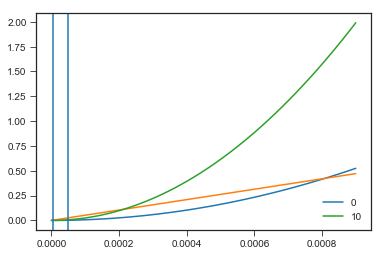

In [52]:
sigmas = np.linspace(1e-7,9e-4)
# np.sqrt(2)*np.sqrt(err)*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
plt.plot(sigmas,[(n_conditions*sigma/s_list[0][1])**2 for sigma in sigmas],label='0')
plt.plot(sigmas,[(np.sqrt(2)*np.sqrt(sigma)*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions)))**2 for sigma in sigmas])
plt.plot(sigmas,[(n_conditions*sigma/s_list[0][9])**2 for sigma in sigmas],label='10')
plt.axvline(5e-6)
plt.axvline(5e-5)
plt.legend()

In [25]:
s_list[0]

array([6.12291302e+00, 6.21167362e-02, 5.31026978e-02, 5.04223926e-02,
       4.98811412e-02, 4.47633734e-02, 4.14939259e-02, 3.68899297e-02,
       3.49024939e-02, 3.18923386e-02, 3.99664385e-03, 2.15172473e-04,
       2.07483380e-04, 2.00158484e-04, 1.96501665e-04, 1.92698564e-04,
       1.91882943e-04, 1.87571542e-04, 1.84559725e-04, 1.80189701e-04,
       1.77131728e-04, 1.75940804e-04, 1.74171432e-04, 1.69161600e-04,
       1.67632943e-04, 1.64639271e-04, 1.61315970e-04, 1.60838854e-04,
       1.56708540e-04, 1.55204305e-04, 1.53685257e-04, 1.50130394e-04,
       1.46791460e-04, 1.45905266e-04, 1.44140634e-04, 1.41770275e-04,
       1.41266208e-04, 1.37137585e-04, 1.30082253e-04, 1.28107821e-04,
       1.26908760e-04, 1.24535215e-04, 1.21502657e-04, 1.19876752e-04,
       1.15902670e-04, 1.13708992e-04, 1.07611154e-04, 1.03393595e-04,
       1.02375101e-04, 9.98927061e-05])

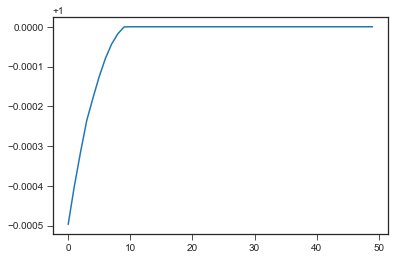

In [20]:
d_true = 10
mutant_center = np.asarray([1.0]+[0.0]*(d_true-1))
condition_points = []
for c in range(n_conditions):
#             condition_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
    condition_points.append(list(nball_pull(d_true,0.05,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
mutant_points = []
for m in range(n_mutants):
#             mutant_points.append(list(nball_pull(d_true,1.0,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
    mutant_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
Ancestor = np.asarray([2.0]+[0.0]*(d_true-1))
Mutants = Ancestor + np.asarray(mutant_points)
Conditions = np.asarray(condition_points)
f = calculate_fitness(Mutants,Conditions,Ancestor)
plt.plot(SVD_fits(f)[0])

2.2882456112707375e-09 0.264887008917972
2.2882456112707375e-06 0.264887008917972
2.2882456112707376e-05 0.264887008917972
0.00022882456112707376 0.264887008917972
0.002288245611270737 0.264887008917972


Text(0,0.5,'Contribution of Singular Value')

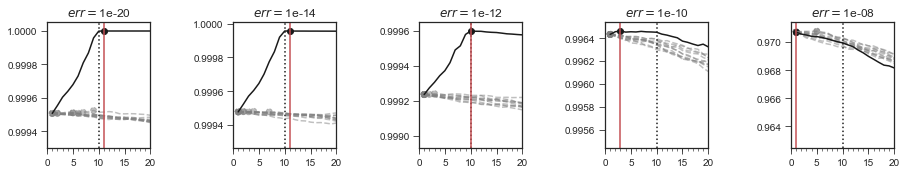

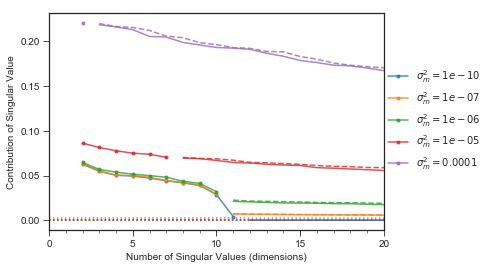

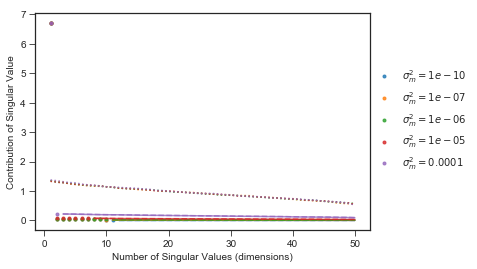

In [11]:
# n_mutants = 250
# n_conditions = 50
# d_true = 10
# mutant_center = np.asarray([1.0]+[0.0]*(d_true-1))
# condition_points = []
# for c in range(n_conditions):
# #             condition_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
#     condition_points.append(list(nball_pull(d_true,0.05,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
# mutant_points = []
# for m in range(n_mutants):
# #             mutant_points.append(list(nball_pull(d_true,1.0,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
#     mutant_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
# Ancestor = np.asarray([2.0]+[0.0]*(d_true-1))
# Mutants = Ancestor + np.asarray(mutant_points)
# Conditions = np.asarray(condition_points)
# f = calculate_fitness(Mutants,Conditions,Ancestor)
# plt.plot(SVD_fits(f)[0])

n_mutants = f.shape[0]
n_conditions = f.shape[1]
n_folds = 5
max_rank = int((n_folds-1)*n_conditions/n_folds)
n_permutations = 10
mutant_permutation = np.random.permutation(n_mutants)
new_mutants = [sorted(mutant_permutation[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
condition_permtutation = np.random.permutation(n_conditions)
new_conditions = [sorted(condition_permtutation[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]

n_trials = 1

s_list = []
noise_list = []
perm_s_list = []
mean_error = []

folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]
counter = 1
fig = plt.figure(figsize=(15,5))
# err_list = [1e-10,0.00001,0.0001,0.001,0.0025,0.005,0.01,0.5]
err_list = [1e-10,1e-7,1e-6,1e-5,1e-4]
for err in err_list:
    for trial in range(n_trials):
        ax = plt.subplot(2,5,counter)
        
        epsilons = np.asarray([np.random.normal(0,np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
        
        # non-uniform error 
#         errors = np.random.uniform(err-err/2,err+err/2,len(f.flatten()))
#         epsilons = np.asarray([np.random.normal(0,np.sqrt(errors[i])) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
        
        # each mutant has error
#         err = np.sqrt(err)
#         errors = np.linspace(err-99*err/100,err+99*err/100,f.shape[0])
#         errors = errors**2
# #         errors = np.random.uniform(err-19*err/20,err+3*err/4,f.shape[0]) 
#         epsilons = np.asarray([np.random.normal(0,np.sqrt(errors[i]))  for i in range(f.shape[0]) for j in range(f.shape[1])]).reshape(f.shape[0],f.shape[1])

        # each condition has error
#         errors = np.random.uniform(err-99*err/100,err+99*err/100,,f.shape[1])
#         err = np.sqrt(err)
#         errors = np.linspace(err-99*err/100,err+99*err/100,f.shape[1])
#         errors = errors**2
#         epsilons = np.asarray([np.random.normal(0,np.sqrt(errors[j]))  for i in range(f.shape[0]) for j in range(f.shape[1])]).reshape(f.shape[0],f.shape[1])


        # multivariate
#         epsilons = np.asarray(np.random.multivariate_normal(np.zeros(len(f.flatten()))))

        err = err**2
#         errors = errors**2
        mean_error.append(err)
        print(np.sqrt(2)*np.sqrt(err)*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions)),np.sqrt(2)*np.sqrt(np.mean(errors))*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions)))
#         epsilons = np.asarray([np.random.normal(0,np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])


        this_set = f + epsilons
        U, s, V = np.linalg.svd(this_set)
        s_list.append(s)
        U, noise_s, V = np.linalg.svd(epsilons)
        noise_list.append(noise_s)
        
        U, perm_s, V = np.linalg.svd(np.random.permutation(this_set.flatten()).reshape((this_set.shape[0],this_set.shape[1])))
        perm_s_list.append(perm_s)
        
        plt.title(r'$err=${0:.3g}'.format(err))
        true_var_explained = var_explained(this_set,f)[0]

        real_fits,true_fits = SVD_predictions(this_set,f,folds,n_mutants,n_conditions,n_folds,mse=False)
        real_fits = real_fits/n_folds
    #         true_fits = true_fits/n_folds

        for perm in range(n_permutations):
            permuted_mutants = copy.copy(this_set)

            perm_fits, true_fits = SVD_predictions(permuted_mutants,f,folds,n_mutants,n_conditions,n_folds,permuted_mutants=True,mse=False)
            perm_fits = perm_fits/n_folds


            plt.plot(range(1,max_rank+1),perm_fits,color='gray',label=d_true,alpha=0.5,linestyle='--')
            plt.scatter(range(1,max_rank+1)[np.where(perm_fits==np.max(perm_fits))[0][0]],np.max(perm_fits),color='gray',alpha=0.5,linestyle='--')

        plt.plot(range(1,max_rank+1),real_fits,color='k',label=d_true,alpha=1.0)
        plt.scatter(range(1,max_rank+1)[np.where(real_fits==np.max(real_fits))[0][0]],np.max(real_fits),color='k',alpha=1.0)

        plt.axvline(x=d_true,color='k',linestyle=':')
        plt.axvline(x=range(1,max_rank+1)[np.where(real_fits==np.max(real_fits))[0][0]],color='r',linestyle='-')
        plt.xlim(0,20)
        plt.xticks(np.arange(0,25,5),np.arange(0,25,5))
        plt.gca().set_xticks(range(20),True)
#         plt.gca().set_xticks(np.arange(0,25,5),False)
#         plt.xticks(np.arange(20,5))
    counter += 1
fig.tight_layout()
plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)

plt.figure()
###### plt.plot(SVD_fits(f)[0],label=0)
end = len(err_list)
max_d = 50
true_d = 10
for e in range(len(err_list[:end])):
    err = err_list[e]
    
    s = s_list[e]
    noise_s = noise_list[e]
    perm_s = perm_s_list[e]
    

    if np.any((s < noise_s[0])):
        max_detectable = np.where(s < noise_s[0])[0][0]
    else:
        max_detectable = max_d
    
    line, = plt.plot(np.arange(2,max_detectable+1),s[1:max_detectable],marker='.',alpha=0.8,label=r'$\sigma_m^2 ={}$'.format(err))
    plt.plot(np.arange(max_detectable+1,len(s)+1),s[max_detectable:],color = line.get_color(),alpha=0.8)
    plt.plot(range(max_detectable+1,max_d+1),noise_s[:max_d-max_detectable],'--',color = line.get_color(),alpha=0.8)
#     plt.plot(np.arange(1,max_d+1),perm_s,linestyle=':',color = line.get_color(),alpha=0.8)
    
    # empirical max
#     plt.axhline(noise_s[0],linestyle=':',color = line.get_color(),alpha=0.8)
    
    # expected theoretical max
#     err = mean_error[e]
    sv = np.sqrt(2)*err*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
    plt.axhline(sv,linestyle=':',color = line.get_color(),alpha=0.8)
    
plt.legend(loc=(1.0,0.25))
plt.xlabel('Number of Singular Values (dimensions)')
plt.ylabel('Contribution of Singular Value')
plt.xlim(0,20)
plt.xticks(np.arange(0,25,5),np.arange(0,25,5))
plt.gca().set_xticks(range(20),True)

plt.figure()
###### plt.plot(SVD_fits(f)[0],label=0)
end = len(err_list)
max_d = 50
true_d = 10
for e in range(len(err_list[:end])):
    err = err_list[e]
    
    s = s_list[e]
    noise_s = noise_list[e]
    perm_s = perm_s_list[e]
    
    if np.any((s < noise_s[0])):
        max_detectable = np.where(s < noise_s[0])[0][0]
    else:
        max_detectable = max_d
    
    line, = plt.plot(np.arange(1,max_detectable+1),s[:max_detectable],marker='.',linestyle='',alpha=0.8,label=r'$\sigma_m^2 ={}$'.format(err))

    plt.plot(np.arange(max_detectable+1,len(s)+1),s[max_detectable:],color = line.get_color(),alpha=0.8)
    plt.plot(range(max_detectable+1,max_d+1),noise_s[:max_d-max_detectable],'--',color = line.get_color(),alpha=0.8)
    plt.plot(np.arange(1,max_d+1),perm_s,linestyle=':',color = line.get_color(),alpha=0.8)


    # empirical max
#     plt.axhline(noise_s[0],linestyle=':',color = line.get_color(),alpha=0.8)
    
    # expected theoretical max
#     sv = np.sqrt(2)*np.sqrt(err)*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
#     plt.axhline(sv,linestyle=':',color = line.get_color(),alpha=0.8)
    
plt.legend(loc=(1.0,0.25))
plt.xlabel('Number of Singular Values (dimensions)')
plt.ylabel('Contribution of Singular Value')

# sv_random_matrix_theory = np.sqrt(2)*np.sqrt(np.asarray(err_list))*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
# for sv in sv_random_matrix_theory[:end]:
#     
# plt.savefig('SVDAnalysis/sv_contribution_d10.pdf',bbox_inches='tight')
# plt.xlim(-11,1)

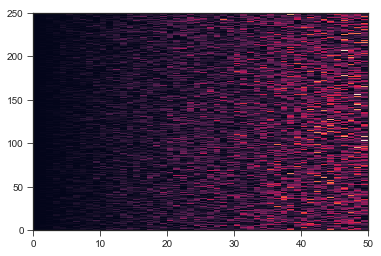

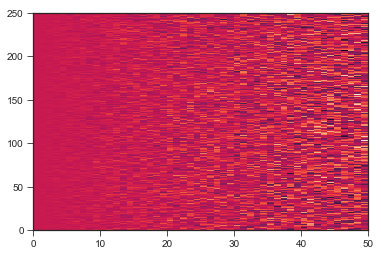

In [33]:
plt.pcolormesh(np.abs(epsilons))
plt.figure()
plt.pcolormesh(epsilons)

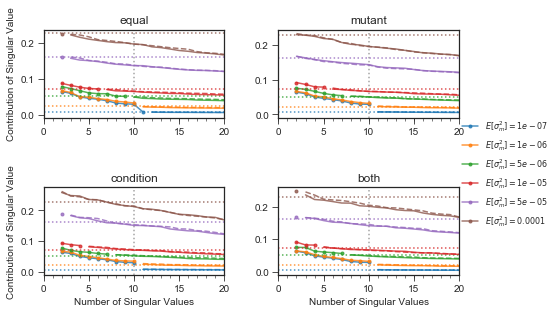

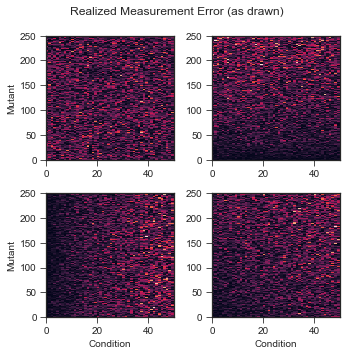

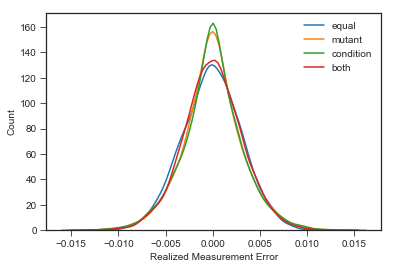

In [112]:
n_mutants = 250
n_conditions = 50
d_true = 10
mutant_center = np.asarray([1.0]+[0.0]*(d_true-1))
condition_points = []
for c in range(n_conditions):
#             condition_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
    condition_points.append(list(nball_pull(d_true,0.05,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
mutant_points = []
for m in range(n_mutants):
#             mutant_points.append(list(nball_pull(d_true,1.0,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
    mutant_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
Ancestor = np.asarray([2.0]+[0.0]*(d_true-1))
Mutants = Ancestor + np.asarray(mutant_points)
Conditions = np.asarray(condition_points)
f = calculate_fitness(Mutants,Conditions,Ancestor)
# plt.plot(SVD_fits(f)[0])

n_mutants = f.shape[0]
n_conditions = f.shape[1]
n_folds = 5
max_rank = int((n_folds-1)*n_conditions/n_folds)
n_permutations = 10
mutant_permutation = np.random.permutation(n_mutants)
new_mutants = [sorted(mutant_permutation[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
condition_permtutation = np.random.permutation(n_conditions)
new_conditions = [sorted(condition_permtutation[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]


folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]
counter = 1
fig = plt.figure(figsize=(9,5))

err_list = [1e-7,1e-6,5e-6,1e-5,5e-5,1e-4]
epsilon_sets = []

error_sets = ['equal','mutant','condition','both']
for e_set in range(len(error_sets)):
    error_set = error_sets[e_set]
    s_list = []
    noise_list = []
    perm_s_list = []
    mean_error = []
    for err in err_list:
        
        if error_set == 'equal':
            epsilons = np.asarray([np.random.normal(0,np.sqrt(err))  for i in range(f.shape[0]) for j in range(f.shape[1])]).reshape(f.shape[0],f.shape[1])
            mean_error.append(err)
            epsilon_sets.append(epsilons)
            
        if error_set == 'mutant':
#             err = np.sqrt(err)
            errors = np.linspace(err-99*err/100,err+99*err/100,f.shape[0])
#             errors = errors**2
            epsilons = np.asarray([np.random.normal(0,np.sqrt(errors[i]))  for i in range(f.shape[0]) for j in range(f.shape[1])]).reshape(f.shape[0],f.shape[1])
            mean_error.append(np.mean(errors))
            epsilon_sets.append(epsilons)

        if error_set == 'condition':
            
#             err = np.sqrt(err)
            errors = np.linspace(err-99*err/100,err+99*err/100,f.shape[1])
#             errors = errors**2
            epsilons = np.asarray([np.random.normal(0,np.sqrt(errors[j]))  for i in range(f.shape[0]) for j in range(f.shape[1])]).reshape(f.shape[0],f.shape[1])
            mean_error.append(np.mean(errors))
            epsilon_sets.append(epsilons)

        if error_set == 'both':
            
#             err = np.sqrt(err)
            condition_errors = np.linspace(err-99*err/100,err+99*err/100,f.shape[1])
#             condition_errors = condition_errors**2
            mutant_errors = np.linspace(err-99*err/100,err+99*err/100,f.shape[0])
#             mutant_errors = mutant_errors**2
            epsilons = np.asarray([np.random.normal(0,np.sqrt(condition_errors[j]/2+mutant_errors[i]/2))  for i in range(f.shape[0]) for j in range(f.shape[1])]).reshape(f.shape[0],f.shape[1])
            errors = np.zeros((f.shape[0],f.shape[1]))
            for i in range(f.shape[0]):
                for j in range(f.shape[1]):
                    errors[i][j] = condition_errors[j]/2+mutant_errors[i]/2
            mean_error.append(np.mean(errors))
            epsilon_sets.append(epsilons)

        err = err**2

        this_set = f + epsilons
        U, s, V = np.linalg.svd(this_set)
        s_list.append(s)
        U, noise_s, V = np.linalg.svd(epsilons)
        noise_list.append(noise_s)

#         U, perm_s, V = np.linalg.svd(np.random.permutation(this_set.flatten()).reshape((this_set.shape[0],this_set.shape[1])))
#         perm_s_list.append(perm_s)

#         plt.title(r'$err=${0:.3g}'.format(err))
#         true_var_explained = var_explained(this_set,f)[0]

#         real_fits,true_fits = SVD_predictions(this_set,f,folds,n_mutants,n_conditions,n_folds,mse=False)
#         real_fits = real_fits/n_folds
#     #         true_fits = true_fits/n_folds

#         for perm in range(n_permutations):
#             permuted_mutants = copy.copy(this_set)

#             perm_fits, true_fits = SVD_predictions(permuted_mutants,f,folds,n_mutants,n_conditions,n_folds,permuted_mutants=True,mse=False)
#             perm_fits = perm_fits/n_folds


#             plt.plot(range(1,max_rank+1),perm_fits,color='gray',label=d_true,alpha=0.5,linestyle='--')
#             plt.scatter(range(1,max_rank+1)[np.where(perm_fits==np.max(perm_fits))[0][0]],np.max(perm_fits),color='gray',alpha=0.5,linestyle='--')

#         plt.plot(range(1,max_rank+1),real_fits,color='k',label=d_true,alpha=1.0)
#         plt.scatter(range(1,max_rank+1)[np.where(real_fits==np.max(real_fits))[0][0]],np.max(real_fits),color='k',alpha=1.0)

#         plt.axvline(x=d_true,color='k',linestyle=':')
#         plt.axvline(x=range(1,max_rank+1)[np.where(real_fits==np.max(real_fits))[0][0]],color='r',linestyle='-')
#         plt.xlim(0,20)
#         plt.xticks(np.arange(0,25,5),np.arange(0,25,5))
#         plt.gca().set_xticks(range(20),True)
#     #         plt.gca().set_xticks(np.arange(0,25,5),False)
#     #         plt.xticks(np.arange(20,5))
#         counter += 1
#     fig.tight_layout()
#     plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)

    plt.subplot(2,2,e_set+1)
    ###### plt.plot(SVD_fits(f)[0],label=0)
    end = len(err_list)
    max_d = 50
    true_d = 10
    plt.axvline(true_d,linestyle=':',color ='k',alpha=0.4)
    for e in range(len(err_list[:end])):
        err = err_list[e]

        s = s_list[e]
        noise_s = noise_list[e]
#         perm_s = perm_s_list[e]


        if np.any((s < noise_s[0])):
            max_detectable = np.where(s < noise_s[0])[0][0]
        else:
            max_detectable = max_d

        line, = plt.plot(np.arange(2,max_detectable+1),s[1:max_detectable],marker='.',alpha=0.8,label=r'$E[\sigma_m^2] ={}$'.format(err))
        plt.plot(np.arange(max_detectable+1,len(s)+1),s[max_detectable:],color = line.get_color(),alpha=0.8)
        plt.plot(range(max_detectable+1,max_d+1),noise_s[:max_d-max_detectable],'--',color = line.get_color(),alpha=0.8)
    #     plt.plot(np.arange(1,max_d+1),perm_s,linestyle=':',color = line.get_color(),alpha=0.8)

        # empirical max
    #     plt.axhline(noise_s[0],linestyle=':',color = line.get_color(),alpha=0.8)

        # expected theoretical max
        err = mean_error[e]
        sv = np.sqrt(2)*np.sqrt(err)*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
        plt.axhline(sv,linestyle=':',color = line.get_color(),alpha=0.8)
        
    plt.title(error_set)
    if e_set in [0,2]:
        plt.ylabel('Contribution of Singular Value')
    if e_set in [2,3]:
        plt.xlabel('Number of Singular Values')
    
    plt.xlim(0,20)
    plt.xticks(np.arange(0,25,5),np.arange(0,25,5))
    plt.gca().set_xticks(range(20),True)
plt.legend(loc=(1.0,0.5),fontsize=8)
fig.tight_layout()
plt.subplots_adjust(left=0.2, wspace=0.3, top=0.8)
plt.savefig('SVDAnalysis/uneven_error.pdf',bbox_inches='tight')

offset = 3
eps_figure = plt.figure(figsize=(5,5))
for e_set in range(len(error_sets)):
    plt.subplot(2,2,e_set+1)
    plt.pcolormesh(np.abs(epsilon_sets[len(err_list)*e_set+offset]),
                   vmin=np.min(np.abs(np.asarray([epsilon_sets[len(err_list)*e_set+offset] for e in range(len(error_sets))]))), 
                    vmax=np.max(np.abs(np.asarray([epsilon_sets[len(err_list)*e_set+offset] for e in range(len(error_sets))]))))
    if e_set in [0,2]:
        plt.ylabel('Mutant')
    if e_set in [2,3]:
        plt.xlabel('Condition')
#     plt.pcolormesh(epsilon_sets[len(err_list)*e_set+offset])
plt.suptitle('Realized Measurement Error (as drawn)')
eps_figure.tight_layout()

plt.subplots_adjust(wspace=0.3, top=0.9)
plt.savefig('SVDAnalysis/uneven_error_heatmaps.pdf',bbox_inches='tight')

# eps_figure = plt.figure(figsize=(9,5))
plt.figure()
for e_set in range(len(error_sets)):
    sns.distplot(epsilon_sets[len(err_list)*e_set+offset].flatten(),hist=False,label=error_sets[e_set])
plt.legend()
plt.xlabel('Realized Measurement Error')
plt.ylabel('Count')
plt.savefig('SVDAnalysis/uneven_error_kdes.pdf',bbox_inches='tight')


In [18]:
d_true = 10
mutant_center = np.asarray([1.0]+[0.0]*(d_true-1))
condition_points = []
for c in range(n_conditions):
#             condition_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
    condition_points.append(list(nball_pull(d_true,0.05,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
mutant_points = []
for m in range(n_mutants):
#             mutant_points.append(list(nball_pull(d_true,1.0,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
    mutant_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
Ancestor = np.asarray([2.0]+[0.0]*(d_true-1))
Mutants = Ancestor + np.asarray(mutant_points)
Conditions = np.asarray(condition_points)
f = calculate_fitness(Mutants,Conditions,Ancestor)
# plt.plot(SVD_fits(f)[0])

In [ ]:
plt.figure()
###### plt.plot(SVD_fits(f)[0],label=0)
err_list = [1e-10,1e-7,5e-6,7.5e-6,1e-5,2.4e-5,5e-5]
end = len(err_list)
max_d = 50
true_d = 2
for e in range(len(err_list[:end])):
    err = err_list[e]
    
    s = s_list[e]**2/(np.sum(s_list[e]**2))
    noise_s = noise_list[e]**2/(np.sum(s_list[e]**2))
    

    if err != err_list[0]:
        max_detectable = np.where(s < noise_s[0])[0][0]
    else:
        max_detectable = true_d+1
    
    line, = plt.plot(np.arange(2,max_detectable+1),s[1:max_detectable],marker='.',alpha=0.8,label=r'$\sigma_m^2 ={}$'.format(err))
    plt.plot(np.arange(max_detectable+1,len(s)+1),s[max_detectable:],color = line.get_color(),alpha=0.8)
    plt.plot(range(max_detectable+1,max_d+1),noise_s[:max_d-max_detectable],'--',color = line.get_color(),alpha=0.8)
    
    # empirical max
#     plt.axhline(noise_s[0],linestyle=':',color = line.get_color(),alpha=0.8)
    
    # expected theoretical max
    sv = np.sqrt(2)*np.sqrt(err)*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
    plt.axhline(sv,linestyle=':',color = line.get_color(),alpha=0.8)
    
plt.legend(loc=(1.0,0.25))
plt.xlabel('Number of Singular Values (dimensions)')
plt.ylabel('Contribution of Singular Value')
plt.xlim(0,20)
plt.xticks(np.arange(0,25,5),np.arange(0,25,5))
plt.gca().set_xticks(range(20),True)

IndexError: list index out of range

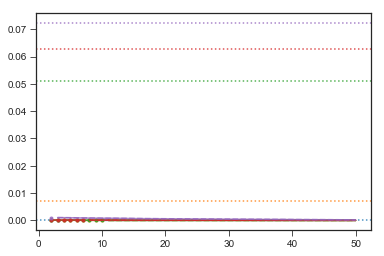

In [19]:
plt.figure()
###### plt.plot(SVD_fits(f)[0],label=0)
err_list = [1e-10,1e-7,5e-6,7.5e-6,1e-5,2.4e-5,5e-5]
end = len(err_list)
max_d = 50
true_d = 2
for e in range(len(err_list[:end])):
    err = err_list[e]
    
    s = s_list[e]**2/(np.sum(s_list[e]**2))
    noise_s = noise_list[e]**2/(np.sum(s_list[e]**2))
    

    if err != err_list[0]:
        max_detectable = np.where(s < noise_s[0])[0][0]
    else:
        max_detectable = true_d+1
    
    line, = plt.plot(np.arange(2,max_detectable+1),s[1:max_detectable],marker='.',alpha=0.8,label=r'$\sigma_m^2 ={}$'.format(err))
    plt.plot(np.arange(max_detectable+1,len(s)+1),s[max_detectable:],color = line.get_color(),alpha=0.8)
    plt.plot(range(max_detectable+1,max_d+1),noise_s[:max_d-max_detectable],'--',color = line.get_color(),alpha=0.8)
    
    # empirical max
#     plt.axhline(noise_s[0],linestyle=':',color = line.get_color(),alpha=0.8)
    
    # expected theoretical max
    sv = np.sqrt(2)*np.sqrt(err)*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
    plt.axhline(sv,linestyle=':',color = line.get_color(),alpha=0.8)
    
plt.legend(loc=(1.0,0.25))
plt.xlabel('Number of Singular Values (dimensions)')
plt.ylabel('Contribution of Singular Value')
plt.xlim(0,20)
plt.xticks(np.arange(0,25,5),np.arange(0,25,5))
plt.gca().set_xticks(range(20),True)

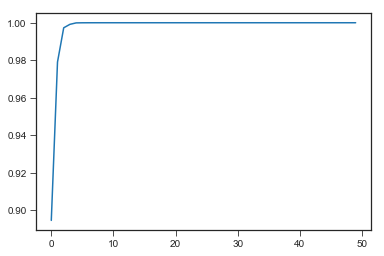

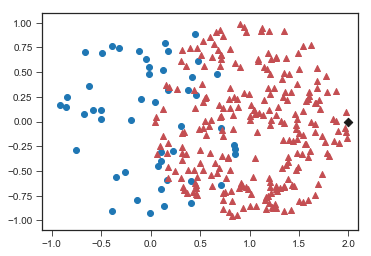

In [78]:
n_mutants = 250
n_conditions = 50



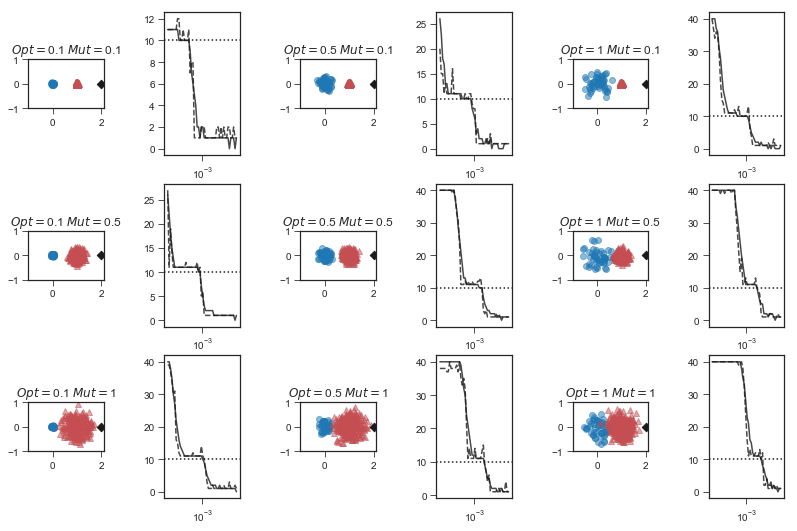

In [113]:
d_true = 10
sims = [(0.1,0.1),(0.5,0.1),(1.0,0.1),(0.1,0.5),(0.5,0.5),(1.0,0.5),(0.1,1.0),(0.5,1.0),(1.0,1.0)]
plt.figure(figsize=(15,10))
for sim in range(len(sims)):
    opt_spread = sims[sim][0]
    mut_spread = sims[sim][1]
    
    
    mutant_center = np.asarray([1.0]+[0.0]*(d_true-1))
    
    condition_points = []
    for c in range(n_conditions):
    #             condition_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
        condition_points.append(list(nball_pull(d_true,opt_spread,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
    mutant_points = []
    for m in range(n_mutants):
    #             mutant_points.append(list(nball_pull(d_true,1.0,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
        mutant_points.append(list(nball_pull(d_true,mut_spread,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
    Ancestor = np.asarray([2.0]+[0.0]*(d_true-1))
    Mutants = Ancestor + np.asarray(mutant_points)
    Conditions = np.asarray(condition_points)
    f = calculate_fitness(Mutants,Conditions,Ancestor)
#     plt.plot(SVD_fits(f)[0])
    
    ax = plt.subplot(3,6,2*sim+1)
    plt.scatter(np.asarray(condition_points).swapaxes(0,1)[0],np.asarray(condition_points).swapaxes(0,1)[1],alpha=0.5)
    plt.scatter((mutant_center+np.asarray(mutant_points)).swapaxes(0,1)[0],(mutant_center+np.asarray(mutant_points)).swapaxes(0,1)[1],color='r',marker='^',alpha=0.5)
    plt.scatter(Ancestor[0],Ancestor[1],color='k',marker='D')
#     plt.xlim(0-opt_spread-0.1,1+mut_spread+0.1)
#     plt.ylim(0-opt_spread-0.1,0+max(opt_spread,mut_spread)+0.1)
    plt.xlim(-1,2.1)
    plt.ylim(-1,1)

    plt.gca().set_aspect('equal')



    n_mutants = f.shape[0]
    n_conditions = f.shape[1]
    n_folds = 5
    max_rank = int((n_folds-1)*n_conditions/n_folds)
    n_permutations = 10
    mutant_permutation = np.random.permutation(n_mutants)
    new_mutants = [sorted(mutant_permutation[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
    condition_permtutation = np.random.permutation(n_conditions)
    new_conditions = [sorted(condition_permtutation[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]



    n_trials = 1

    folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]
    d_list = []
    max_detect_list = []
    # fig = plt.figure(figsize=(15,5))
    # err_list = [1e-10,0.00001,0.0001,0.001,0.0025,0.005,0.01,0.5]
    # err_list = [1e-8,5e-5,1e-7,,1e-6,1e-5,1e-4,1e-2,1e-1,1.0,10.0]
    err_list = [1e-8*10**n for n in range(9)]
    five_err_list = [5*x for x in err_list]
    err_list = list(chain.from_iterable(zip(err_list, five_err_list)))
    err_list = np.logspace(-8,2)
    for err in err_list:
    #     ax = plt.subplot(2,5,counter)

        epsilons = np.asarray([np.random.normal(0,np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
        this_set = f + epsilons
        U, s, V = np.linalg.svd(this_set)
        s_list.append(s)
        U, noise_s, V = np.linalg.svd(epsilons)
        noise_list.append(noise_s)

        U, perm_s, V = np.linalg.svd(np.random.permutation(this_set.flatten()).reshape((this_set.shape[0],this_set.shape[1])))
        perm_s_list.append(perm_s)

        plt.title(r'$Opt=${0:.2g} $Mut=${1:.2g}'.format(opt_spread,mut_spread))
        true_var_explained = var_explained(this_set,f)[0]

        real_fits,true_fits = SVD_predictions(this_set,f,folds,n_mutants,n_conditions,n_folds,mse=False)
        real_fits = real_fits/n_folds

        d_list.append(range(1,max_rank+1)[np.where(real_fits==np.max(real_fits))[0][0]])
        if np.any((s < noise_s[0])):
            if np.where(s < noise_s[0])[0][0] < max_rank:
                max_detect_list.append(np.where(s < noise_s[0])[0][0])
            else:
                max_detect_list.append(max_rank)
        else:
            max_detect_list.append(max_rank)
    ax = plt.subplot(3,6,2*sim+2)
    plt.plot(err_list,d_list,color='k',linestyle='--',alpha=0.8,label='Cross Validation')
    plt.plot(err_list,max_detect_list,color='k',alpha=0.8,label='SVD Contribution')
    plt.axhline(y=d_true,color='k',linestyle=':')
    plt.xscale('log')
# plt.legend()
fig.tight_layout()
plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
plt.savefig('SVDAnalysis/detectability_by_spreads_explicit.pdf',bbox_inches='tight')

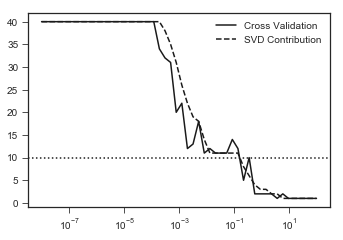

In [101]:
plt.figure()
plt.plot(err_list,d_list,color='k',label='Cross Validation')
plt.plot(err_list,max_detect_list,color='k',linestyle='--',label='SVD Contribution')
plt.axhline(y=d_true,color='k',linestyle=':')
plt.xscale('log')
plt.legend()
fig.tight_layout()
plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)

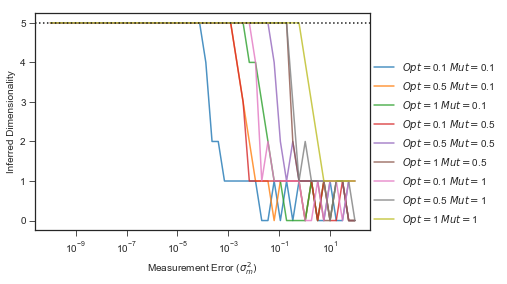

In [55]:
d_true = 5

n_mutants = 250
n_conditions = 50
n_folds = 10
sims = [(0.1,0.1),(0.5,0.1),(1.0,0.1),(0.1,0.5),(0.5,0.5),(1.0,0.5),(0.1,1.0),(0.5,1.0),(1.0,1.0)]
s_list = []
noise_list = []
perm_s_list = []
max_detect_list = []
plt.figure()
for sim in range(len(sims)):
    opt_spread = sims[sim][0]
    mut_spread = sims[sim][1]
    
    
    mutant_center = np.asarray([0.0]+[0.0]*(d_true-1))
    
    condition_points = []
    for c in range(n_conditions):
    #             condition_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
        condition_points.append(list(nball_pull(d_true,opt_spread,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
    mutant_points = []
    for m in range(n_mutants):
    #             mutant_points.append(list(nball_pull(d_true,1.0,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
        mutant_points.append(list(nball_pull(d_true,mut_spread,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
    Ancestor = np.asarray([0.0]+[0.0]*(d_true-1))
    Mutants = Ancestor + np.asarray(mutant_points)
    Conditions = np.asarray(condition_points)
    f = calculate_fitness_linear(Mutants,Conditions,Ancestor)
#     plt.plot(SVD_fits(f)[0])
    
#     ax = plt.subplot(3,6,2*sim+1)
#     plt.scatter(np.asarray(condition_points).swapaxes(0,1)[0],np.asarray(condition_points).swapaxes(0,1)[1],alpha=0.5)
#     plt.scatter((mutant_center+np.asarray(mutant_points)).swapaxes(0,1)[0],(mutant_center+np.asarray(mutant_points)).swapaxes(0,1)[1],color='r',marker='^',alpha=0.5)
#     plt.scatter(Ancestor[0],Ancestor[1],color='k',marker='D')
# #     plt.xlim(0-opt_spread-0.1,1+mut_spread+0.1)
# #     plt.ylim(0-opt_spread-0.1,0+max(opt_spread,mut_spread)+0.1)
#     plt.xlim(-1,2.1)
#     plt.ylim(-1,1)

#     plt.gca().set_aspect('equal')



    n_mutants = f.shape[0]
    n_conditions = f.shape[1]
    
    max_rank = int((n_folds-1)*n_conditions/n_folds)
    n_permutations = 10
    mutant_permutation = np.random.permutation(n_mutants)
    new_mutants = [sorted(mutant_permutation[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
    condition_permtutation = np.random.permutation(n_conditions)
    new_conditions = [sorted(condition_permtutation[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]



    n_trials = 1

    folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]
    d_list = []
    max_detect_list = []
    # fig = plt.figure(figsize=(15,5))
    # err_list = [1e-10,0.00001,0.0001,0.001,0.0025,0.005,0.01,0.5]
    # err_list = [1e-8,5e-5,1e-7,,1e-6,1e-5,1e-4,1e-2,1e-1,1.0,10.0]
#     err_list = [1e-8*10**n for n in range(9)]
#     five_err_list = [5*x for x in err_list]
#     err_list = list(chain.from_iterable(zip(err_list, five_err_list)))
    err_list = np.logspace(-10,2)
    for err in err_list:
    #     ax = plt.subplot(2,5,counter)

        epsilons = np.asarray([np.random.normal(0,np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
        this_set = f + epsilons
        U, s, V = np.linalg.svd(this_set)
        s_list.append(s)
        U, noise_s, V = np.linalg.svd(epsilons)
        noise_list.append(noise_s)

        U, perm_s, V = np.linalg.svd(np.random.permutation(this_set.flatten()).reshape((this_set.shape[0],this_set.shape[1])))
        perm_s_list.append(perm_s)

#         plt.title(r'$Opt=${0:.2g} $Mut=${1:.2g}'.format(opt_spread,mut_spread))
        true_var_explained = var_explained(this_set,f)[0]

        real_fits,true_fits = SVD_predictions(this_set,f,folds,n_mutants,n_conditions,n_folds,mse=False)
        real_fits = real_fits/n_folds

        d_list.append(range(1,max_rank+1)[np.where(real_fits==np.max(real_fits))[0][0]])
        if np.any((s < noise_s[0])):
            if np.where(s < noise_s[0])[0][0] < max_rank:
                max_detect_list.append(np.where(s < noise_s[0])[0][0])
            else:
                max_detect_list.append(max_rank)
        else:
            max_detect_list.append(max_rank)
#     ax = plt.subplot(3,6,2*sim+2)
#     line, = plt.plot(err_list,d_list,linestyle='--',alpha=0.8,label=r'$Opt=${0:.2g} $Mut=${1:.2g}'.format(opt_spread,mut_spread))
#     plt.plot(err_list,max_detect_list,color=line.get_color(),alpha=0.8)
    plt.plot(err_list,max_detect_list,alpha=0.8,label=r'$Opt=${0:.2g} $Mut=${1:.2g}'.format(opt_spread,mut_spread))
plt.axhline(y=d_true,color='k',linestyle=':')
plt.xscale('log')
plt.legend(loc=(1.0,0.0))
plt.xlabel(r'Measurement Error ($\sigma_m^2$)')
plt.ylabel('Inferred Dimensionality')
# plt.savefig('SVDAnalysis/LINEAR_detectability_by_spreads_both_d{}_{}folds.pdf'.format(d_true,n_folds),bbox_inches='tight')
# plt.savefig('SVDAnalysis/detectability_by_spreads_justCV_d{}_{}folds.pdf'.format(d_true,n_folds),bbox_inches='tight')
plt.savefig('SVDAnalysis/LINEAR_detectability_by_spreads_justsvd_d{}_{}folds.pdf'.format(d_true,n_folds),bbox_inches='tight')

ValueError: x and y must have same first dimension, but have shapes (50,) and (1,)

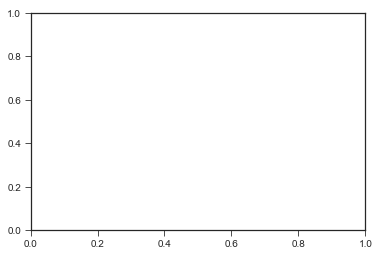

In [120]:
d_true = 10

n_mutants = 250
n_conditions = 50
fold_list = [2,5,10,25,50]
sims = [(0.5,0.5)]
plt.figure()
for sim in range(len(sims)):
    opt_spread = sims[sim][0]
    mut_spread = sims[sim][1]


    mutant_center = np.asarray([1.0]+[0.0]*(d_true-1))

    condition_points = []
    for c in range(n_conditions):
        #             condition_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
        condition_points.append(list(nball_pull(d_true,opt_spread,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
    mutant_points = []
    for m in range(n_mutants):
    #             mutant_points.append(list(nball_pull(d_true,1.0,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
        mutant_points.append(list(nball_pull(d_true,mut_spread,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
    Ancestor = np.asarray([2.0]+[0.0]*(d_true-1))
    Mutants = Ancestor + np.asarray(mutant_points)
    Conditions = np.asarray(condition_points)
    f = calculate_fitness(Mutants,Conditions,Ancestor)
    err_list = np.logspace(-10,2)
    for err in err_list:
    #     ax = plt.subplot(2,5,counter)

        epsilons = np.asarray([np.random.normal(0,np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
        this_set = f + epsilons
        U, s, V = np.linalg.svd(this_set)
        s_list.append(s)
        U, noise_s, V = np.linalg.svd(epsilons)
        noise_list.append(noise_s)

        U, perm_s, V = np.linalg.svd(np.random.permutation(this_set.flatten()).reshape((this_set.shape[0],this_set.shape[1])))
        perm_s_list.append(perm_s)
        
        for n_folds in fold_list:

            n_mutants = f.shape[0]
            n_conditions = f.shape[1]

            max_rank = int((n_folds-1)*n_conditions/n_folds)
            n_permutations = 10
            mutant_permutation = np.random.permutation(n_mutants)
            new_mutants = [sorted(mutant_permutation[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
            condition_permtutation = np.random.permutation(n_conditions)
            new_conditions = [sorted(condition_permtutation[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]


            folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]
            d_list = []
            max_detect_list = []
            
            true_var_explained = var_explained(this_set,f)[0]

            real_fits,true_fits = SVD_predictions(this_set,f,folds,n_mutants,n_conditions,n_folds,mse=False)
            real_fits = real_fits/n_folds

            d_list.append(range(1,max_rank+1)[np.where(real_fits==np.max(real_fits))[0][0]])
            if np.any((s < noise_s[0])):
                if np.where(s < noise_s[0])[0][0] < max_rank:
                    max_detect_list.append(np.where(s < noise_s[0])[0][0])
                else:
                    max_detect_list.append(max_rank)
            else:
                max_detect_list.append(max_rank)

        line, = plt.plot(err_list,d_list,,alpha=0.8,label=r'{} folds'.format(n_folds))
    #     plt.plot(err_list,max_detect_list,color=line.get_color(),alpha=0.8)
    #     plt.plot(err_list,max_detect_list,alpha=0.8,label=r'$Opt=${0:.2g} $Mut=${1:.2g}'.format(opt_spread,mut_spread))
plt.axhline(y=d_true,color='k',linestyle=':')
plt.xscale('log')
plt.legend(loc=(1.0,0.0))
plt.xlabel(r'Measurement Error ($\sigma_m^2$)')
plt.ylabel('Inferred Dimensionality')
plt.savefig('SVDAnalysis/detectability_by_folds_justCV_d{}.pdf'.format(d_true,n_folds),bbox_inches='tight')
# plt.savefig('SVDAnalysis/detectability_by_spreads_justsvd_d{}_{}folds.pdf'.format(d_true,n_folds),bbox_inches='tight')

ValueError: x and y must have same first dimension, but have shapes (50,) and (5,)

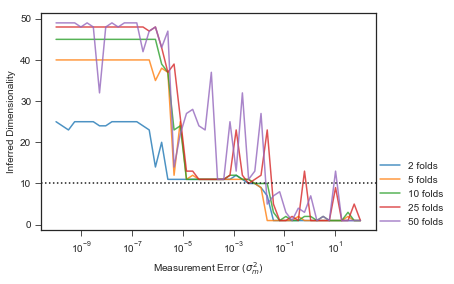

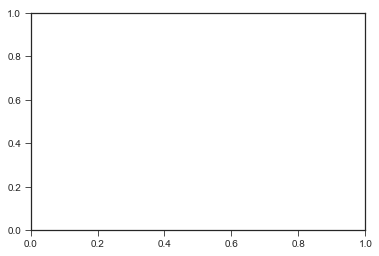

In [17]:
d_true = 10

n_mutants = 250
n_conditions = 50
fold_list = [2,5,10,25,50]
sims = [(0.5,0.5)]
plt.figure()
for sim in range(len(sims)):
    opt_spread = sims[sim][0]
    mut_spread = sims[sim][1]


    mutant_center = np.asarray([1.0]+[0.0]*(d_true-1))

    condition_points = []
    for c in range(n_conditions):
        #             condition_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
        condition_points.append(list(nball_pull(d_true,opt_spread,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
    mutant_points = []
    for m in range(n_mutants):
    #             mutant_points.append(list(nball_pull(d_true,1.0,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
        mutant_points.append(list(nball_pull(d_true,mut_spread,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
    Ancestor = np.asarray([2.0]+[0.0]*(d_true-1))
    Mutants = Ancestor + np.asarray(mutant_points)
    Conditions = np.asarray(condition_points)
    f = calculate_fitness(Mutants,Conditions,Ancestor)
    err_list = np.logspace(-10,2)
    
    d_list = []
    fit_list = []
    for e in range(len(err_list)):
        err = err_list[e]
        d_list.append([])
        fit_list.append([])
        
        s_list = []
        noise_list = []
    #     ax = plt.subplot(2,5,counter)

        epsilons = np.asarray([np.random.normal(0,np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
        this_set = f + epsilons
        U, s, V = np.linalg.svd(this_set)
        s_list.append(s)
        U, noise_s, V = np.linalg.svd(epsilons)
        noise_list.append(noise_s)
        if np.any((s < noise_s[0])):
            if np.where(s < noise_s[0])[0][0] < max_rank:
                max_detect_list.append(np.where(s < noise_s[0])[0][0])
            else:
                max_detect_list.append(max_rank)
        else:
            max_detect_list.append(max_rank)

#         U, perm_s, V = np.linalg.svd(np.random.permutation(this_set.flatten()).reshape((this_set.shape[0],this_set.shape[1])))
#         perm_s_list.append(perm_s)
        
        for n_folds in fold_list:

            n_mutants = f.shape[0]
            n_conditions = f.shape[1]

            max_rank = int((n_folds-1)*n_conditions/n_folds)
            n_permutations = 10
            mutant_permutation = np.random.permutation(n_mutants)
            new_mutants = [sorted(mutant_permutation[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
            condition_permtutation = np.random.permutation(n_conditions)
            new_conditions = [sorted(condition_permtutation[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]


            folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]
#             d_list[e] = []
            max_detect_list = []
            
            true_var_explained = var_explained(this_set,f)[0]

            real_fits,true_fits = SVD_predictions(this_set,f,folds,n_mutants,n_conditions,n_folds,mse=False)
            real_fits = real_fits/n_folds

            d_list[e].append(range(1,max_rank+1)[np.where(real_fits==np.max(real_fits))[0][0]])
            fit_list[e].append(np.max(real_fits))
    
    d_list = np.asarray(d_list).swapaxes(0,1)
    for f in range(len(fold_list)):
        
        line, = plt.plot(err_list,d_list[f],alpha=0.8,label=r'{} folds'.format(fold_list[f]))
    #     plt.plot(err_list,max_detect_list,color=line.get_color(),alpha=0.8)
    #     plt.plot(err_list,max_detect_list,alpha=0.8,label=r'$Opt=${0:.2g} $Mut=${1:.2g}'.format(opt_spread,mut_spread))
plt.axhline(y=d_true,color='k',linestyle=':')
plt.xscale('log')
plt.legend(loc=(1.0,0.0))
plt.xlabel(r'Measurement Error ($\sigma_m^2$)')
plt.ylabel('Inferred Dimensionality')
plt.savefig('SVDAnalysis/detectability_by_folds_justCV_d{}.pdf'.format(d_true,n_folds),bbox_inches='tight')

fit_list = np.asarray(fit_list).swapaxes(0,1)
plt.figure()
for f in range(len(fold_list)):     
    line, = plt.plot(err_list,fit_list[f],alpha=0.8,label=r'{} folds'.format(fold_list[f]))

# plt.axhline(y=d_true,color='k',linestyle=':')
plt.xscale('log')
plt.legend(loc=(1.0,0.0))
plt.xlabel(r'Measurement Error ($\sigma_m^2$)')
plt.ylabel('Inferred Dimensionality')
plt.savefig('SVDAnalysis/fit_by_folds_justCV_d{}.pdf'.format(d_true,n_folds),bbox_inches='tight')
# plt.savefig('SVDAnalysis/detectability_by_spreads_justsvd_d{}_{}folds.pdf'.format(d_true,n_folds),bbox_inches='tight')

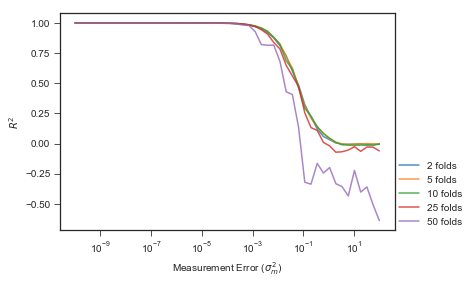

In [22]:
fit_list = np.asarray(fit_list).swapaxes(0,1)
plt.figure()
for f in range(len(fold_list)):     
    line, = plt.plot(err_list,fit_list[f],alpha=0.8,label=r'{} folds'.format(fold_list[f]))

# plt.axhline(y=d_true,color='k',linestyle=':')
plt.xscale('log')
plt.legend(loc=(1.0,0.0))
plt.xlabel(r'Measurement Error ($\sigma_m^2$)')
plt.ylabel(r'$R^2$')
plt.savefig('SVDAnalysis/fit_by_folds_justCV_d{}.pdf'.format(d_true,n_folds),bbox_inches='tight')

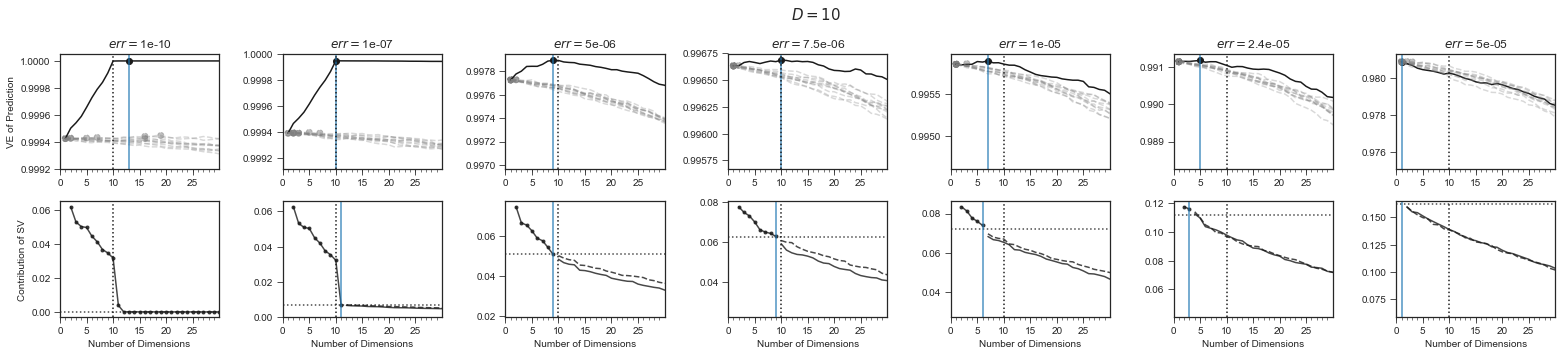

In [20]:
n_mutants = f.shape[0]
n_conditions = f.shape[1]
max_rank = int((n_folds-1)*n_conditions/n_folds)
n_permutations = 10
mutant_permutation = np.random.permutation(n_mutants)
new_mutants = [sorted(mutant_permutation[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
condition_permtutation = np.random.permutation(n_conditions)
new_conditions = [sorted(condition_permtutation[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]

n_trials = 1

s_list = []
noise_list = []
perm_s_list = []

folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]
counter = 1

err_list = [1e-10,0.00001,0.0001,0.001,0.0025,0.005,0.01,0.5]
err_list = [1e-10,1e-7,5e-6,7.5e-6,1e-5,2.4e-5,5e-5]

fig = plt.figure(figsize=(3*len(err_list),5))


for err in err_list:
    for trial in range(n_trials):
        ax = plt.subplot(2,len(err_list),counter)
        if counter == 1:
            plt.ylabel('VE of Prediction')
        
        epsilons = np.asarray([np.random.normal(0,np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
        this_set = f + epsilons
        U, s, V = np.linalg.svd(this_set)
        s_list.append(s)
        U, noise_s, V = np.linalg.svd(epsilons)
        noise_list.append(noise_s)
        
        U, perm_s, V = np.linalg.svd(np.random.permutation(this_set.flatten()).reshape((this_set.shape[0],this_set.shape[1])))
        perm_s_list.append(perm_s)
        

        true_var_explained = var_explained(this_set,f)[0]

        real_fits,true_fits = SVD_predictions(this_set,f,folds,n_mutants,n_conditions,n_folds,mse=False)
        real_fits = real_fits/n_folds
        
        line, = plt.plot(range(1,max_rank+1),real_fits,color='k',label=d_true,alpha=1.0)
        plt.scatter(range(1,max_rank+1)[np.where(real_fits==np.max(real_fits))[0][0]],np.max(real_fits),color=line.get_color(),alpha=1.0)



        for perm in range(n_permutations):
            permuted_mutants = copy.copy(this_set)

            perm_fits, true_fits = SVD_predictions(permuted_mutants,f,folds,n_mutants,n_conditions,n_folds,permuted_mutants=True,mse=False)
            perm_fits = perm_fits/n_folds


            plt.plot(range(1,max_rank+1),perm_fits,label=d_true,alpha=0.3,color='gray',linestyle='--')
            plt.scatter(range(1,max_rank+1)[np.where(perm_fits==np.max(perm_fits))[0][0]],np.max(perm_fits),color='gray',alpha=0.5,linestyle='--')

        plt.axvline(x=range(1,max_rank+1)[np.where(real_fits==np.max(real_fits))[0][0]],linestyle='-',alpha=0.8)
        plt.axvline(x=d_true,color='k',linestyle=':')
        
#         plt.xlim(0,20)
#         plt.xticks(np.arange(0,25,5),np.arange(0,25,5))
#         plt.gca().set_xticks(range(20),True)
        plt.xlim(0,30)
        plt.xticks(np.arange(0,30,5),np.arange(0,30,5))
        plt.gca().set_xticks(range(30),True)
        plt.title(r'$err=${0:.3g}'.format(err))
#         plt.gca().set_xticks(np.arange(0,25,5),False)
#         plt.xticks(np.arange(20,5))
    counter += 1


# plt.figure()
###### plt.plot(SVD_fits(f)[0],label=0)
end = len(err_list)
max_d = 50
true_d = 5
for e in range(len(err_list[:end])):
    ax = plt.subplot(2,len(err_list),counter)
    
    if e == 0:
        plt.ylabel('Contribution of SV')
    
    err = err_list[e]
    
    s = s_list[e]
    noise_s = noise_list[e]
    perm_s = perm_s_list[e]
    

    if err != err_list[0]:
        max_detectable = np.where(s < noise_s[0])[0][0]
    else:
        max_detectable = max_d
    
    line, = plt.plot(np.arange(2,max_detectable+1),s[1:max_detectable],color='k',marker='.',alpha=0.8,label=r'$\sigma_m^2 ={}$'.format(err))
    plt.plot(np.arange(max_detectable+1,len(s)+1),s[max_detectable:],color = line.get_color(),alpha=0.8)
    plt.plot(range(max_detectable+1,max_d+1),noise_s[:max_d-max_detectable],'--',color = line.get_color(),alpha=0.8)
#     plt.plot(np.arange(1,max_d+1),perm_s,linestyle=':',color = line.get_color(),alpha=0.8)
    
    # empirical max
#     plt.axhline(noise_s[0],linestyle=':',color = line.get_color(),alpha=0.8)
    
    # expected theoretical max
    sv = np.sqrt(2)*np.sqrt(err)*np.sqrt((n_mutants+n_conditions)/2+ np.sqrt(n_mutants*n_conditions))
    plt.axhline(sv,linestyle=':',color = line.get_color(),alpha=0.8)
    plt.axvline(x=max_detectable,linestyle='-',alpha=0.8)
    plt.axvline(x=d_true,color='k',linestyle=':')
    
    counter += 1
#     plt.xlim(0,20)
#     plt.xticks(np.arange(0,25,5),np.arange(0,25,5))
#     plt.gca().set_xticks(range(20),True)
    plt.xlim(0,30)
    plt.xticks(np.arange(0,30,5),np.arange(0,30,5))
    plt.gca().set_xticks(range(30),True)
    plt.xlabel('Number of Dimensions')
    
plt.suptitle(r'$D={}$'.format(d_true),fontsize=15)

fig.tight_layout()
plt.subplots_adjust(left=0.0, wspace=0.4, top=0.85)
# plt.savefig('SVDAnalysis/prediction_contrib_comparison_d{}.pdf'.format(d_true),bbox_inches='tight')

In [ ]:
d_true = 5
sims = [(0.1,0.1),(0.5,0.1),(1.0,0.1),(0.1,0.5),(0.5,0.5),(1.0,0.5),(0.1,1.0),(0.5,1.0),(1.0,1.0)]
for sim in range(len(sims)) 
    opt_spread = sims[sim][0]
    mut_spread = sims[sim][1]
    
    
    mutant_center = np.asarray([1.0]+[0.0]*(d_true-1))
    
    condition_points = []
    for c in range(n_conditions):
    #             condition_points.append(list(nball_pull(d_true,0.1,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
        condition_points.append(list(nball_pull(d_true,opt_spread,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
    mutant_points = []
    for m in range(n_mutants):
    #             mutant_points.append(list(nball_pull(d_true,1.0,[1.0]+[1.0]*(d_true-1),fixed_radius=True)))
        mutant_points.append(list(nball_pull(d_true,mut_spread,[1.0]+[1.0]*(d_true-1),fixed_radius=False)))
    Ancestor = np.asarray([2.0]+[0.0]*(d_true-1))
    Mutants = Ancestor + np.asarray(mutant_points)
    Conditions = np.asarray(condition_points)
    f = calculate_fitness(Mutants,Conditions,Ancestor)
    plt.plot(SVD_fits(f)[0])
    plt.figure()
    plt.scatter(np.asarray(condition_points).swapaxes(0,1)[0],np.asarray(condition_points).swapaxes(0,1)[1])
    plt.scatter((mutant_center+np.asarray(mutant_points)).swapaxes(0,1)[0],(mutant_center+np.asarray(mutant_points)).swapaxes(0,1)[1],color='r',marker='^')
    plt.scatter(Ancestor[0],Ancestor[1],color='k',marker='D')
    plt.xlim(0-opt_spread-0.1,1+mut_spread+0.1)
    plt.ylim(0-opt_spread-0.1,0+max(opt_spread,mut_spread)+0.1)

    plt.gca().set_aspect('equal')



    n_mutants = f.shape[0]
    n_conditions = f.shape[1]
    n_folds = 5
    max_rank = int((n_folds-1)*n_conditions/n_folds)
    n_permutations = 10
    mutant_permutation = np.random.permutation(n_mutants)
    new_mutants = [sorted(mutant_permutation[(i)*int(n_mutants/n_folds):(i+1)*int(n_mutants/n_folds)]) for i in range(n_folds)]
    condition_permtutation = np.random.permutation(n_conditions)
    new_conditions = [sorted(condition_permtutation[(i)*int(n_conditions/n_folds):(i+1)*int(n_conditions/n_folds)]) for i in range(n_folds)]



    n_trials = 1

    folds = [(new_mutants[fold],new_conditions[fold]) for fold in range(n_folds)]
    d_list = []
    max_detect_list = []
    # fig = plt.figure(figsize=(15,5))
    # err_list = [1e-10,0.00001,0.0001,0.001,0.0025,0.005,0.01,0.5]
    # err_list = [1e-8,5e-5,1e-7,,1e-6,1e-5,1e-4,1e-2,1e-1,1.0,10.0]
    err_list = [1e-8*10**n for n in range(9)]
    five_err_list = [5*x for x in err_list]
    err_list = list(chain.from_iterable(zip(err_list, five_err_list)))
    err_list = np.logspace(-8,2)
    for err in err_list:
    #     ax = plt.subplot(2,5,counter)

        epsilons = np.asarray([np.random.normal(0,np.sqrt(err)) for i in range(len(f.flatten()))]).reshape(f.shape[0],f.shape[1])
        this_set = f + epsilons
        U, s, V = np.linalg.svd(this_set)
        s_list.append(s)
        U, noise_s, V = np.linalg.svd(epsilons)
        noise_list.append(noise_s)

        U, perm_s, V = np.linalg.svd(np.random.permutation(this_set.flatten()).reshape((this_set.shape[0],this_set.shape[1])))
        perm_s_list.append(perm_s)

        plt.title(r'$err=${0:.3g}'.format(err))
        true_var_explained = var_explained(this_set,f)[0]

        real_fits,true_fits = SVD_predictions(this_set,f,folds,n_mutants,n_conditions,n_folds,mse=False)
        real_fits = real_fits/n_folds

        d_list.append(range(1,max_rank+1)[np.where(real_fits==np.max(real_fits))[0][0]])
        if np.any((s < noise_s[0])):
            if np.where(s < noise_s[0])[0][0] < max_rank:
                max_detect_list.append(np.where(s < noise_s[0])[0][0])
            else:
                max_detect_list.append(max_rank)
        else:
            max_detect_list.append(max_rank)
    
    plt.plot(err_list,d_list,color='b',label='Cross Validation')
    plt.plot(err_list,max_detect_list,color='r',label='SVD Contribution')
    plt.axhline(y=d_true,color='k',linestyle=':')
    plt.xscale('log')
plt.legend()
fig.tight_layout()
plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)